# Parkinson's Disease Detection from fMRI Data on AWS SageMaker

This notebook implements a machine learning pipeline for detecting Parkinson's disease from functional MRI (fMRI) data.
Based on neuroimaging research methodologies for movement disorder classification.

## Overview
- **Objective**: Classify Parkinson's disease patients vs. healthy controls using fMRI features
- **Approach**: Extract functional connectivity and regional activity features
- **Methods**: Support Vector Machine, Random Forest, and Logistic Regression classifiers
- **Validation**: Cross-validation with performance metrics

## Prerequisites
- AWS SageMaker notebook instance in us-east-2 region
- fMRI data stored in S3 (preprocessed with fMRIPrep)
- Required libraries: nilearn, scikit-learn, tensorflow, nibabel

## Dataset Structure Expected
```
s3://bucket/datasets/Parkinsonsdisease58/ds005892-download/
├── sub-0203/
│   ├── func/
│   │   └── sub-MJF012_task-rest_bold.nii.gz
│   └── anat/
│       └── sub-MJF012_T1w.nii.gz
└── sub-1001/
    ├── func/
    │   └── sub-MJF012_task-rest_bold.nii.gz
    └── anat/
        └── sub-MJF012_T1w.nii.gz
```

## 1. Environment Setup and Library Installation

In [2]:
# Install required packages for Parkinson's detection
!pip install seaborn scikit-learn tensorflow pandas numpy matplotlib 
!pip install nilearn nibabel boto3 sagemaker plotly imbalanced-learn
#!pip install xgboost lightgbm optuna scipy statsmodels

## 2. AWS SageMaker Configuration

In [4]:
import sagemaker
import os
import boto3

# Initialize SageMaker session and get default bucket
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
prefix = 'datasets'

# Initialize S3 client
s3_client = boto3.client('s3')

# Set up local directories
data_dir = '/tmp/fmri_data'
output_dir = '/tmp/results'
models_dir = '/tmp/models'

os.makedirs(data_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

print(f"SageMaker role: {role}")
print(f"S3 bucket: {bucket}")
print(f"Data directory: {data_dir}")
print(f"Output directory: {output_dir}")
print(f"Models directory: {models_dir}")

SageMaker role: arn:aws:iam::257967673968:role/parkinson-fmri-notebook-stack-SageMakerNotebookRole-6Dt9LfTmian7
S3 bucket: sagemaker-us-east-2-257967673968
Data directory: /tmp/fmri_data
Output directory: /tmp/results
Models directory: /tmp/models


In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
import sklearn
warnings.filterwarnings('ignore')

# fMRI and neuroimaging imports
import nibabel as nib
from nilearn import datasets, plotting, image
from nilearn.input_data import NiftiLabelsMasker, NiftiMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.plotting import plot_connectome, plot_matrix
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix

# Machine learning imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE

# Deep learning imports
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("Libraries imported successfully!")
# print(f"TensorFlow version: {tf.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")

Libraries imported successfully!
Scikit-learn version: 1.8.0


## 3. Data Loading from S3 - Parkinson's Dataset

### 3.1. Download Data from S3

This cell downloads fMRI data from S3 to local storage. It handles the Parkinson's dataset structure and creates fallback sample data if S3 data is not available.

In [6]:
def load_fmri_dataset_with_tsv(s3_bucket, s3_prefix='datasets', participants_tsv_path=None):
    """
    Load fMRI dataset from S3 with labels from participants TSV file
    
    Parameters:
    -----------
    s3_bucket : str
        S3 bucket name
    s3_prefix : str
        S3 prefix for dataset
    participants_tsv_path : str
        Path to participants.tsv file (local or S3)
    
    Expected S3 structure:
    s3://bucket/datasets/Parkinsonsdisease58/ds005892-download/sub-XXXX/func/
    s3://bucket/datasets/Parkinsonsdisease58/ds005892-download/sub-XXXX/anat/
    
    Expected TSV format:
    participant_id	group	age	sex
    sub-MJF001	PD-MCI	68	M
    sub-MJF003	Control	68	M
    
    Returns:
    --------
    func_paths: List of functional fMRI file paths
    anat_paths: List of anatomical T1w file paths  
    labels: List of labels (0=control, 1=patient)
    subject_ids: List of subject identifiers
    demographics: DataFrame with participant demographics
    """
    import pandas as pd
    import os
    
    func_paths = []
    anat_paths = []
    labels = []
    subject_ids = []
    demographics = None
    
    print(f"Loading Parkinson's disease dataset from S3 bucket: {s3_bucket}")
    print(f"Searching in prefix: {s3_prefix}/Parkinsonsdisease58/ds005892-download/")
    
    # Load participants TSV file
    participants_df = load_participants_tsv(participants_tsv_path, s3_bucket, s3_prefix)
        
    print(f"✅ Loaded participants file with {len(participants_df)} subjects")
    print(f"Groups found: {participants_df['group'].value_counts().to_dict()}")
    
    # Create label mapping
    label_mapping = create_label_mapping(participants_df)
    
    try:
        # List all objects in the Parkinson's dataset
        paginator = s3_client.get_paginator('list_objects_v2')
        pages = paginator.paginate(
            Bucket=s3_bucket, 
            Prefix=f'{s3_prefix}/Parkinsonsdisease58/ds005892-download/'
        )
        
        subjects_found = set()
        
        for page in pages:
            if 'Contents' in page:
                for obj in page['Contents']:
                    key = obj['Key']
                    
                    # Parse the S3 key to extract subject info
                    key_parts = key.split('/')
                    
                    if len(key_parts) >= 6 and key.endswith('.nii.gz'):
                        subject_folder = key_parts[3]  # sub-XXXX
                        # session_folder = key_parts[4]  # ses-XX
                        data_type = key_parts[4]       # func or anat
                        filename = key_parts[5]        # actual filename
                        
                        if subject_folder.startswith('sub-'):
                            # Get label from TSV file
                            if subject_folder in label_mapping:
                                label = label_mapping[subject_folder]['label']
                                group = label_mapping[subject_folder]['group']
                                
                                subject_id = subject_folder.replace('sub-', '')
                                #session_id = session_folder.replace('ses-', '')
                                full_subject_id = f"{subject_id}"
                                
                                # Create local directory structure
                                local_dir = os.path.join(data_dir, subject_folder, data_type)
                                os.makedirs(local_dir, exist_ok=True)
                                local_path = os.path.join(local_dir, filename)
                                
                                # Download the file
                                try:
                                    s3_client.download_file(s3_bucket, key, local_path)
                                    
                                    # Categorize by data type
                                    if data_type == 'func' and ('task-rest' in filename or 'bold' in filename):
                                        func_paths.append(local_path)
                                        if full_subject_id not in subjects_found:
                                            labels.append(label)
                                            subject_ids.append(full_subject_id)
                                            subjects_found.add(full_subject_id)
                                            
                                    elif data_type == 'anat' and 'T1w' in filename:
                                        anat_paths.append(local_path)
                                        
                                    print(f"Downloaded: {filename} for subject {full_subject_id} ({group})")
                                    
                                except Exception as e:
                                    print(f"Error downloading {key}: {e}")
                            else:
                                print(f"⚠️ Subject {subject_folder} not found in participants file")
        
        # Create demographics dataframe for downloaded subjects
        demographics = create_demographics_df(participants_df, subject_ids)
        
        print(f"\n📊 Dataset Summary:")
        print(f"- Total subjects: {len(subjects_found)}")
        print(f"- Functional files: {len(func_paths)}")
        print(f"- Anatomical files: {len(anat_paths)}")
        print(f"- Controls: {len([l for l in labels if l == 0])}")
        print(f"- Patients: {len([l for l in labels if l == 1])}")
        
        # Show group breakdown
        if demographics is not None:
            print(f"\n📋 Group Breakdown:")
            group_counts = demographics['group'].value_counts()
            for group, count in group_counts.items():
                print(f"  - {group}: {count}")
        
    except Exception as e:
        print(f"Error loading dataset: {e}")
        #return create_sample_dataset()
    
    # If no real data available, create sample data for demonstration
    if len(func_paths) == 0:
        print("\n⚠️ No Parkinson's dataset found in S3. Creating sample dataset...")
        #return create_sample_dataset()
    
    return func_paths, anat_paths, labels, subject_ids, demographics

def load_participants_tsv(participants_tsv_path, s3_bucket=None, s3_prefix=None):
    """
    Load participants TSV file from local path or S3
    """
    import pandas as pd
    
    if participants_tsv_path is None:
        # Try to find participants.tsv in common locations
        possible_paths = [
            'participants.tsv',
            'data/participants.tsv',
            '/tmp/fmri_data/participants.tsv',
            f'{data_dir}/participants.tsv'
        ]
        
        # Also try S3 locations
        if s3_bucket and s3_prefix:
            s3_paths = [
                #f'{s3_prefix}/participants.tsv',
                #f'{s3_prefix}/Parkinsonsdisease58/participants.tsv',
                f'{s3_prefix}/Parkinsonsdisease58/ds005892-download/participants.tsv'
            ]
            
            for s3_path in s3_paths:
                try:
                    local_tsv_path = os.path.join(data_dir, 'participants.tsv')
                    s3_client.download_file(s3_bucket, s3_path, local_tsv_path)
                    print(f"✅ Downloaded participants.tsv from S3: {s3_path}")
                    participants_tsv_path = local_tsv_path
                    break
                except Exception as e:
                    print(f"❌ Failed to download from S3 {s3_path}: {e}")
        
        # Try local paths
        if participants_tsv_path is None:
            for path in possible_paths:
                if os.path.exists(path):
                    participants_tsv_path = path
                    print(f"✅ Found local participants.tsv: {path}")
                    break
    
    if participants_tsv_path is None:
        print("❌ No participants.tsv file found")
        return None
    
    try:
        # Load TSV file
        df = pd.read_csv(participants_tsv_path, sep='\t')
        
        # Validate required columns
        required_columns = ['participant_id', 'group']
        missing_columns = [col for col in required_columns if col not in df.columns]
        
        if missing_columns:
            print(f"❌ Missing required columns in TSV: {missing_columns}")
            print(f"Available columns: {list(df.columns)}")
            return None
        
        # Clean and standardize data
        df['participant_id'] = df['participant_id'].astype(str)
        df['group'] = df['group'].astype(str)
        
        # Remove any rows with missing participant_id or group
        df = df.dropna(subset=['participant_id', 'group'])
        
        print(f"✅ Loaded {len(df)} participants from TSV")
        print(f"Columns: {list(df.columns)}")
        
        return df
        
    except Exception as e:
        print(f"❌ Error loading participants TSV: {e}")
        return None

def create_label_mapping(participants_df):
    """
    Create mapping from participant_id to labels based on group column
    """
    label_mapping = {}
    
    for _, row in participants_df.iterrows():
        participant_id = row['participant_id']
        group = row['group']
        
        # Determine if control or patient
        # Control groups: 'Control', 'HC', 'Healthy', etc.
        # Patient groups: 'PD', 'PD-MCI', 'PD-NC', 'Patient', etc.
        
        is_control = any(control_term in group.upper() for control_term in 
                        ['CONTROL', 'HC', 'HEALTHY', 'CTL', 'CON'])
        
        label = 0 if is_control else 1  # 0 = control, 1 = patient
        
        label_mapping[participant_id] = {
            'label': label,
            'group': group
        }
    
    # Print mapping summary
    controls = sum(1 for v in label_mapping.values() if v['label'] == 0)
    patients = sum(1 for v in label_mapping.values() if v['label'] == 1)
    
    print(f"📊 Label mapping created:")
    print(f"  - Controls: {controls}")
    print(f"  - Patients: {patients}")
    
    # Show unique groups
    unique_groups = set(v['group'] for v in label_mapping.values())
    print(f"  - Unique groups: {sorted(unique_groups)}")
    
    return label_mapping

def create_demographics_df(participants_df, subject_ids):
    """
    Create demographics dataframe for successfully downloaded subjects
    """
    # Extract base subject IDs (remove session info)
    base_subject_ids = []
    for subj_id in subject_ids:
        if '_' in subj_id:
            base_id = subj_id.split('_')[0]
        else:
            base_id = subj_id
        base_subject_ids.append(f"sub-{base_id}")
    
    # Filter participants_df to only include downloaded subjects
    demographics = participants_df[
        participants_df['participant_id'].isin(base_subject_ids)
    ].copy()
    
    # Add processed subject IDs
    demographics['processed_subject_id'] = subject_ids
    
    return demographics

# Updated data loading cell with TSV support
def enhanced_data_loading_with_tsv(s3_bucket=None, s3_prefix='datasets', participants_tsv_path=None):
    """
    Enhanced data loading function with TSV file support
    """
    print("🚀 Starting enhanced data loading with TSV support...")
    
    # Discover S3 buckets and download data
    try:
        if s3_client:
            region = 'us-east-2'
            buckets = s3_client.list_buckets()['Buckets']
            fmri_buckets = [b['Name'] for b in buckets if 'fmri' in b['Name'].lower()]
            if fmri_buckets:
                bucket = fmri_buckets[0]
                print(f"✅ Using existing fMRI bucket: {bucket}")
            else:
                bucket = f"sagemaker-{region}-{boto3.client('sts').get_caller_identity()['Account']}"
                print(f"🔄 Using default bucket pattern: {bucket}")
        else:
            bucket = "demo-bucket"
            print("⚠️ S3 client not available, using demo bucket name")
    except Exception as e:
        print(f"❌ Error discovering S3 buckets: {e}")
        bucket = "demo-bucket"

    # Download the dataset with TSV support
    func_paths, anat_paths, labels, subject_ids, demographics = load_fmri_dataset_with_tsv(
        bucket, s3_prefix, participants_tsv_path
    )

    print(f"\n" + "="*60)
    print("📊 DATA DOWNLOAD COMPLETED WITH TSV LABELS")
    print(f"Total subjects: {len(func_paths)}")
    print(f"Controls: {labels.count(0)}")
    print(f"Patients: {labels.count(1)}")
    print(f"Functional files: {len(func_paths)}")
    print(f"Anatomical files: {len(anat_paths)}")
    print(f"Data stored in: {data_dir}")
    
    if demographics is not None:
        print(f"\n📋 Demographics Summary:")
        if 'age' in demographics.columns:
            print(f"Age range: {demographics['age'].min()}-{demographics['age'].max()}")
        if 'sex' in demographics.columns:
            sex_counts = demographics['sex'].value_counts()
            print(f"Sex distribution: {dict(sex_counts)}")
        
        group_counts = demographics['group'].value_counts()
        print(f"Group distribution: {dict(group_counts)}")
    
    print("="*60)
    
    return func_paths, anat_paths, labels, subject_ids, demographics

# Updated DataFrame creation cell
def create_enhanced_dataframe_with_demographics(func_paths, anat_paths, labels, subject_ids, demographics):
    """
    Create enhanced DataFrame with demographics information
    """
    try:
        # Verify that we have data from the previous cell
        if not func_paths or len(func_paths) == 0:
            print("⚠️ No functional paths found from previous cell.")
            print("Please run the previous cell (3.1. Download Data from S3) first.")
            return pd.DataFrame()
        
        # Create base DataFrame
        dataset_df = pd.DataFrame({
            'subject_id': subject_ids,
            'func_path': func_paths,
            'label': labels,
            'group_numeric': labels,  # Keep numeric for ML
            'group': ['control' if l == 0 else 'patient' for l in labels]
        })
        
        # Add anatomical paths if available
        if len(anat_paths) > 0:
            # Match anatomical paths to functional paths by subject ID
            anat_dict = {}
            for anat_path in anat_paths:
                path_parts = anat_path.split('/')
                for part in path_parts:
                    if part.startswith('sub-'):
                        sub_id = part.replace('sub-', '')
                        for session_part in path_parts:
                            if session_part.startswith('ses-'):
                                ses_id = session_part.replace('ses-', '')
                                full_id = f"{sub_id}_{ses_id}"
                                anat_dict[full_id] = anat_path
                                break
                        break
            
            dataset_df['anat_path'] = dataset_df['subject_id'].map(anat_dict)
        
        # Merge with demographics if available
        if demographics is not None and len(demographics) > 0:
            # Create mapping from processed_subject_id to demographics
            demo_dict = demographics.set_index('processed_subject_id').to_dict('index')
            
            # Add demographic columns
            for demo_col in ['group', 'age', 'sex']:
                if demo_col in demographics.columns:
                    if demo_col == 'group':
                        # Use original group names from TSV
                        dataset_df['group_original'] = dataset_df['subject_id'].map(
                            lambda x: demo_dict.get(x, {}).get('group', 'Unknown')
                        )
                    else:
                        dataset_df[demo_col] = dataset_df['subject_id'].map(
                            lambda x: demo_dict.get(x, {}).get(demo_col, None)
                        )
        
        print(f"\n" + "="*60)
        print("📊 ENHANCED DATASET DATAFRAME CREATED")
        print(f"\nDataset Summary:")
        print(f"Total subjects: {len(dataset_df)}")
        print(f"Controls: {len(dataset_df[dataset_df['label'] == 0])}")
        print(f"Patients: {len(dataset_df[dataset_df['label'] == 1])}")
        
        if len(dataset_df) > 0:
            print(f"\n📋 Dataset DataFrame (first 5 rows):")
            display_cols = ['subject_id', 'group_original' if 'group_original' in dataset_df.columns else 'group', 
                          'age', 'sex', 'label'] if 'age' in dataset_df.columns else ['subject_id', 'group', 'label']
            print(dataset_df[display_cols].head())
            
            if 'group_original' in dataset_df.columns:
                print(f"\n📊 Original Group Distribution:")
                print(dataset_df['group_original'].value_counts())
            
            if 'age' in dataset_df.columns:
                print(f"\n📈 Age Statistics:")
                age_stats = dataset_df.groupby('group_original' if 'group_original' in dataset_df.columns else 'group')['age'].describe()
                print(age_stats)
            
            if 'sex' in dataset_df.columns:
                print(f"\n⚥ Sex Distribution by Group:")
                sex_group = pd.crosstab(dataset_df['group_original' if 'group_original' in dataset_df.columns else 'group'], 
                                      dataset_df['sex'])
                print(sex_group)
            
            print(f"\n📁 DataFrame columns: {list(dataset_df.columns)}")
            print(f"📐 DataFrame shape: {dataset_df.shape}")
        else:
            print("\n⚠️ DataFrame is empty - no data was loaded.")
        
        print("="*60)
        
        return dataset_df
        
    except Exception as e:
        print(f"❌ Error creating enhanced DataFrame: {e}")
        return pd.DataFrame()

func_paths, anat_paths, labels, subject_ids, demographic = enhanced_data_loading_with_tsv()
print(func_paths)
print(anat_paths)
print(labels)
print(subject_ids)


🚀 Starting enhanced data loading with TSV support...
✅ Using existing fMRI bucket: fmri-dataset-bucket-257967673968-us-east-2
Loading Parkinson's disease dataset from S3 bucket: fmri-dataset-bucket-257967673968-us-east-2
Searching in prefix: datasets/Parkinsonsdisease58/ds005892-download/
✅ Downloaded participants.tsv from S3: datasets/Parkinsonsdisease58/ds005892-download/participants.tsv
✅ Loaded 55 participants from TSV
Columns: ['participant_id', 'group', 'age', 'sex']
✅ Loaded participants file with 55 subjects
Groups found: {'Control': 22, 'PD-NC': 18, 'PD-MCI': 15}
📊 Label mapping created:
  - Controls: 22
  - Patients: 33
  - Unique groups: ['Control', 'PD-MCI', 'PD-NC']
Downloaded: sub-MJF001_T1w.nii.gz for subject MJF001 (PD-MCI)
Downloaded: sub-MJF001_magnitude1.nii.gz for subject MJF001 (PD-MCI)
Downloaded: sub-MJF001_magnitude2.nii.gz for subject MJF001 (PD-MCI)
Downloaded: sub-MJF001_phasediff.nii.gz for subject MJF001 (PD-MCI)
Downloaded: sub-MJF001_task-rest_bold.nii.gz

## 3.3. fMRI Data Visualization

Let's load and visualize the first control subject's fMRI data to understand the data structure and quality.

In [7]:
# Create DataFrame for easier handling using the paths from the previous cell
try:
    # Verify that we have data from the previous cell
    if 'func_paths' not in locals() or len(func_paths) == 0:
        print("Warning: No functional paths found from previous cell.")
        print("Please run the previous cell (3.1. Download Data from S3) first.")
        # Create empty variables as fallback
        func_paths, anat_paths, labels, subject_ids = [], [], [], []
    
    # Create DataFrame
    dataset_df = pd.DataFrame({
        'subject_id': subject_ids,
        'func_path': func_paths,
        'label': labels,
        'group': ['control' if l == 0 else 'patient' for l in labels]
    })
    
    # Add anatomical paths if available
    if len(anat_paths) > 0:
        # Match anatomical paths to functional paths by subject ID
        anat_dict = {}
        for anat_path in anat_paths:
            # Extract subject ID from path
            path_parts = anat_path.split('/')
            for part in path_parts:
                if part.startswith('sub-'):
                    sub_id = part.replace('sub-', '')
                    # Find session
                    for session_part in path_parts:
                        if session_part.startswith('ses-'):
                            ses_id = session_part.replace('ses-', '')
                            full_id = f"{sub_id}_{ses_id}"
                            anat_dict[full_id] = anat_path
                            break
                    break
        
        # Add anatomical paths to DataFrame
        dataset_df['anat_path'] = dataset_df['subject_id'].map(anat_dict)
    
    print(f"\n" + "="*50)
    print("DATASET DATAFRAME CREATED")
    print(f"\nDataset Summary:")
    print(f"Total subjects: {len(dataset_df)}")
    print(f"Controls: {len(dataset_df[dataset_df['label'] == 0])}")
    print(f"Patients: {len(dataset_df[dataset_df['label'] == 1])}")
    
    if len(dataset_df) > 0:
        print(f"\nDataset DataFrame (first 5 rows):")
        print(dataset_df.head())
        
        print(f"\nGroup distribution:")
        print(dataset_df['group'].value_counts())
        
        print(f"\nDataFrame columns: {list(dataset_df.columns)}")
        print(f"DataFrame shape: {dataset_df.shape}")
    else:
        print("\nDataFrame is empty - no data was loaded.")
    
    print("="*50)
    
except Exception as e:
    print(f"Error creating DataFrame: {e}")
    # Create empty DataFrame as fallback
    dataset_df = pd.DataFrame()
    print("Created empty DataFrame as fallback")


DATASET DATAFRAME CREATED

Dataset Summary:
Total subjects: 55
Controls: 22
Patients: 33

Dataset DataFrame (first 5 rows):
  subject_id                                          func_path  label  \
0     MJF001  /tmp/fmri_data/sub-MJF001/func/sub-MJF001_task...      1   
1     MJF002  /tmp/fmri_data/sub-MJF002/func/sub-MJF002_task...      1   
2     MJF003  /tmp/fmri_data/sub-MJF003/func/sub-MJF003_task...      0   
3     MJF006  /tmp/fmri_data/sub-MJF006/func/sub-MJF006_task...      0   
4     MJF007  /tmp/fmri_data/sub-MJF007/func/sub-MJF007_task...      1   

     group  anat_path  
0  patient        NaN  
1  patient        NaN  
2  control        NaN  
3  control        NaN  
4  patient        NaN  

Group distribution:
group
patient    33
control    22
Name: count, dtype: int64

DataFrame columns: ['subject_id', 'func_path', 'label', 'group', 'anat_path']
DataFrame shape: (55, 5)


In [9]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from nilearn import plotting
import ipywidgets as widgets

def interactive_fmri_viewer(fmri_path):
    """
    Interactive fMRI viewer with sliders for all dimensions
    """
    # Load the fMRI image
    img = nib.load(fmri_path)
    data = img.get_fdata()
    
    print(f"fMRI shape: {data.shape}")
    print("Dimensions: X, Y, Z, Time")
    
    # Create interactive function
    def view_slice(x=data.shape[0]//2, y=data.shape[1]//2, 
                   z=data.shape[2]//2, t=0):
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # Sagittal view (YZ plane, fixed X)
        axes[0,0].imshow(data[x, :, :, t].T, cmap='gray', origin='lower')
        axes[0,0].set_title(f'Sagittal (X={x})')
        axes[0,0].set_xlabel('Y'); axes[0,0].set_ylabel('Z')
        
        # Coronal view (XZ plane, fixed Y)  
        axes[0,1].imshow(data[:, y, :, t].T, cmap='gray', origin='lower')
        axes[0,1].set_title(f'Coronal (Y={y})')
        axes[0,1].set_xlabel('X'); axes[0,1].set_ylabel('Z')
        
        # Axial view (XY plane, fixed Z)
        axes[1,0].imshow(data[:, :, z, t].T, cmap='gray', origin='lower')
        axes[1,0].set_title(f'Axial (Z={z})')
        axes[1,0].set_xlabel('X'); axes[1,0].set_ylabel('Y')
        
        # Time series at current voxel
        voxel_timeseries = data[x, y, z, :]
        axes[1,1].plot(voxel_timeseries)
        axes[1,1].set_title(f'Time Series at ({x},{y},{z})')
        axes[1,1].set_xlabel('Time Point'); axes[1,1].set_ylabel('Signal')
        axes[1,1].axvline(t, color='red', linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.show()
    
    # Create sliders
    x_slider = IntSlider(min=0, max=data.shape[0]-1, step=1, value=data.shape[0]//2)
    y_slider = IntSlider(min=0, max=data.shape[1]-1, step=1, value=data.shape[1]//2)
    z_slider = IntSlider(min=0, max=data.shape[2]-1, step=1, value=data.shape[2]//2)
    t_slider = IntSlider(min=0, max=data.shape[3]-1, step=1, value=0)
    
    # Create interactive widget
    interact(view_slice, 
             x=x_slider, y=y_slider, z=z_slider, t=t_slider)

# Usage
interactive_fmri_viewer(func_paths[0])

fMRI shape: (64, 64, 34, 300)
Dimensions: X, Y, Z, Time


interactive(children=(IntSlider(value=32, description='x', max=63), IntSlider(value=32, description='y', max=6…

In [11]:
from nilearn import plotting, image
import ipywidgets as widgets
from IPython.display import display

def advanced_fmri_viewer(fmri_path):
    """
    Advanced viewer using nilearn's plotting functions
    """
    img = nib.load(fmri_path)
    
    def plot_volume(time_point=0, cut_coords=None, threshold=None):
        # Extract single volume
        vol_img = image.index_img(img, time_point)
        
        # Create the plot
        fig = plt.figure(figsize=(15, 5))
        
        # Plot with nilearn
        display_obj = plotting.plot_stat_map(
            vol_img, 
            cut_coords=cut_coords,
            threshold=threshold,
            colorbar=True,
            figure=fig
        )
        
        plt.suptitle(f'fMRI Volume at Time Point {time_point}')
        plt.show()
    
    # Create widgets
    time_widget = widgets.IntSlider(
        value=0, min=0, max=img.shape[3]-1,
        description='Time Point:'
    )
    
    threshold_widget = widgets.FloatSlider(
        value=0, min=0, max=np.percentile(img.get_fdata(), 95),
        description='Threshold:'
    )
    
    # Interactive plot
    widgets.interact(plot_volume, 
                    time_point=time_widget,
                    threshold=threshold_widget,
                    cut_coords=widgets.fixed(None))

advanced_fmri_viewer(func_paths[0])

interactive(children=(IntSlider(value=0, description='Time Point:', max=299), FloatSlider(value=0.0, descripti…

In [8]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import ipywidgets as widgets

def plotly_fmri_viewer(fmri_path):
    """
    3D interactive viewer using plotly
    """
    img = nib.load(fmri_path)
    data = img.get_fdata()
    
    # Take middle slices for initial view
    mid_x, mid_y, mid_z = [s//2 for s in data.shape[:3]]
    
    def create_3d_plot(time_point=0, opacity=0.5):
        vol_data = data[:, :, :, time_point]
        
        # Create 3D volume plot
        fig = go.Figure(data=go.Volume(
            x=np.arange(data.shape[0]),
            y=np.arange(data.shape[1]), 
            z=np.arange(data.shape[2]),
            value=vol_data.flatten(),
            opacity=opacity,
            surface_count=15,
        ))
        
        fig.update_layout(
            title=f'3D fMRI Volume - Time Point {time_point}',
            scene=dict(
                xaxis_title='X',
                yaxis_title='Y', 
                zaxis_title='Z'
            )
        )
        
        fig.show()
    
    # Create interactive widget
    widgets.interact(create_3d_plot,
                     time_point=widgets.IntSlider(0, 0, data.shape[3]-1))
#                     opacity=widgets.FloatSlider(0.5, 0.1, 1.0, 0.1))


def complete_fmri_dashboard(fmri_path):
    """
    Complete interactive fMRI dashboard
    """
    img = nib.load(fmri_path)
    data = img.get_fdata()
    
    # Normalize data for better visualization
    data_norm = (data - data.min()) / (data.max() - data.min())
    
    def dashboard(x=data.shape[0]//2, y=data.shape[1]//2, 
                 z=data.shape[2]//2, t=0, colormap='gray', 
                 show_crosshairs=True):
        
        fig = plt.figure(figsize=(16, 12))
        
        # Create subplot layout
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
        
        # Three orthogonal views
        ax1 = fig.add_subplot(gs[0, 0])  # Sagittal
        ax2 = fig.add_subplot(gs[0, 1])  # Coronal  
        ax3 = fig.add_subplot(gs[0, 2])  # Axial
        
        # Time series and statistics
        ax4 = fig.add_subplot(gs[1, :])  # Time series
        ax5 = fig.add_subplot(gs[2, 0])  # Histogram
        ax6 = fig.add_subplot(gs[2, 1])  # Mean image
        ax7 = fig.add_subplot(gs[2, 2])  # Std image
        
        current_vol = data_norm[:, :, :, t]
        
        # Sagittal view
        im1 = ax1.imshow(current_vol[x, :, :].T, cmap=colormap, origin='lower')
        ax1.set_title(f'Sagittal (X={x})')
        if show_crosshairs:
            ax1.axhline(z, color='red', alpha=0.7)
            ax1.axvline(y, color='red', alpha=0.7)
        
        # Coronal view
        im2 = ax2.imshow(current_vol[:, y, :].T, cmap=colormap, origin='lower')
        ax2.set_title(f'Coronal (Y={y})')
        if show_crosshairs:
            ax2.axhline(z, color='red', alpha=0.7)
            ax2.axvline(x, color='red', alpha=0.7)
        
        # Axial view
        im3 = ax3.imshow(current_vol[:, :, z].T, cmap=colormap, origin='lower')
        ax3.set_title(f'Axial (Z={z})')
        if show_crosshairs:
            ax3.axhline(y, color='red', alpha=0.7)
            ax3.axvline(x, color='red', alpha=0.7)
        
        # Time series at selected voxel
        voxel_ts = data_norm[x, y, z, :]
        ax4.plot(voxel_ts, 'b-', linewidth=2)
        ax4.axvline(t, color='red', linestyle='--', alpha=0.8)
        ax4.set_title(f'Time Series at Voxel ({x},{y},{z})')
        ax4.set_xlabel('Time Point')
        ax4.set_ylabel('Normalized Signal')
        ax4.grid(True, alpha=0.3)
        
        # Histogram of current volume
        ax5.hist(current_vol.flatten(), bins=50, alpha=0.7, color='skyblue')
        ax5.set_title('Intensity Histogram')
        ax5.set_xlabel('Intensity')
        ax5.set_ylabel('Frequency')
        
        # Mean across time
        mean_img = np.mean(data_norm, axis=3)
        im6 = ax6.imshow(mean_img[:, :, z].T, cmap='hot', origin='lower')
        ax6.set_title('Mean Image (Axial)')
        plt.colorbar(im6, ax=ax6, shrink=0.8)
        
        # Standard deviation across time
        std_img = np.std(data_norm, axis=3)
        im7 = ax7.imshow(std_img[:, :, z].T, cmap='viridis', origin='lower')
        ax7.set_title('Std Dev Image (Axial)')
        plt.colorbar(im7, ax=ax7, shrink=0.8)
        
        plt.suptitle(f'fMRI Interactive Dashboard - Time Point {t}', fontsize=16)
        plt.show()
    
    # Create comprehensive widget interface
    style = {'description_width': 'initial'}
    
    x_widget = widgets.IntSlider(value=data.shape[0]//2, min=0, max=data.shape[0]-1, 
                                description='X coordinate:', style=style)
    y_widget = widgets.IntSlider(value=data.shape[1]//2, min=0, max=data.shape[1]-1,
                                description='Y coordinate:', style=style)
    z_widget = widgets.IntSlider(value=data.shape[2]//2, min=0, max=data.shape[2]-1,
                                description='Z coordinate:', style=style)
    t_widget = widgets.IntSlider(value=0, min=0, max=data.shape[3]-1,
                                description='Time point:', style=style)
    
    colormap_widget = widgets.Dropdown(
        options=['gray', 'hot', 'cool', 'viridis', 'plasma', 'inferno'],
        value='gray', description='Colormap:', style=style
    )
    
    crosshairs_widget = widgets.Checkbox(
        value=True, description='Show crosshairs', style=style
    )
    
    # Display widgets and plot
    ui = widgets.VBox([
        widgets.HBox([x_widget, y_widget]),
        widgets.HBox([z_widget, t_widget]),
        widgets.HBox([colormap_widget, crosshairs_widget])
    ])
    
    out = widgets.interactive_output(dashboard, {
        'x': x_widget, 'y': y_widget, 'z': z_widget, 't': t_widget,
        'colormap': colormap_widget, 'show_crosshairs': crosshairs_widget
    })
    
    display(ui, out)

# Usage
#plotly_fmri_viewer(func_paths[0])
complete_fmri_dashboard(func_paths[0])


Output()

In [20]:
def robust_brain_region_dashboard(fmri_path):
    """
    Brain region dashboard with robust atlas loading and SSL error handling
    """
    import nibabel as nib
    import numpy as np
    import matplotlib.pyplot as plt
    from nilearn import datasets, plotting, image
    from nilearn.input_data import NiftiMasker
    import ipywidgets as widgets
    from IPython.display import display
    import ssl
    import urllib3
    
    # Disable SSL warnings for problematic downloads
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
    
    # Load fMRI data
    fmri_img = nib.load(fmri_path)
    print(f"fMRI shape: {fmri_img.shape}")
    
    def load_robust_atlases():
        """
        Load atlases with robust error handling
        """
        atlases = {}
        
        # Method 1: Harvard-Oxford (most reliable)
        try:
            print("Loading Harvard-Oxford cortical atlas...")
            ho_cort = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
            atlases['Harvard-Oxford Cortical'] = {
                'maps': ho_cort.maps,
                'labels': ho_cort.labels,
                'type': 'volume'
            }
            print("✓ Harvard-Oxford cortical loaded")
        except Exception as e:
            print(f"✗ Harvard-Oxford cortical failed: {e}")
        
        try:
            print("Loading Harvard-Oxford subcortical atlas...")
            ho_sub = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-2mm')
            atlases['Harvard-Oxford Subcortical'] = {
                'maps': ho_sub.maps,
                'labels': ho_sub.labels,
                'type': 'volume'
            }
            print("✓ Harvard-Oxford subcortical loaded")
        except Exception as e:
            print(f"✗ Harvard-Oxford subcortical failed: {e}")
        
        # Method 2: Schaefer atlas (usually reliable)
        for n_rois in [100, 200]:
            try:
                print(f"Loading Schaefer {n_rois} ROI atlas...")
                schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=n_rois, resolution_mm=2)
                atlases[f'Schaefer {n_rois} ROIs'] = {
                    'maps': schaefer.maps,
                    'labels': schaefer.labels,
                    'type': 'volume'
                }
                print(f"✓ Schaefer {n_rois} loaded")
            except Exception as e:
                print(f"✗ Schaefer {n_rois} failed: {e}")
        
        # Method 3: Destrieux atlas
        try:
            print("Loading Destrieux atlas...")
            destrieux = datasets.fetch_atlas_destrieux_2009()
            atlases['Destrieux'] = {
                'maps': destrieux.maps,
                'labels': destrieux.labels,
                'type': 'volume'
            }
            print("✓ Destrieux loaded")
        except Exception as e:
            print(f"✗ Destrieux failed: {e}")
        
        # Method 4: Power coordinates (no download needed)
        try:
            print("Loading Power coordinates...")
            power = datasets.fetch_coords_power_2011()
            atlases['Power Coordinates'] = {
                'coords': power.rois,
                'labels': [f"ROI_{i+1}" for i in range(len(power.rois))],
                'type': 'coordinates'
            }
            print("✓ Power coordinates loaded")
        except Exception as e:
            print(f"✗ Power coordinates failed: {e}")
        
        # Method 5: MSDL atlas (functional networks)
        try:
            print("Loading MSDL functional atlas...")
            msdl = datasets.fetch_atlas_msdl()
            atlases['MSDL Functional'] = {
                'maps': msdl.maps,
                'labels': msdl.labels,
                'networks': msdl.networks,
                'type': 'volume'
            }
            print("✓ MSDL loaded")
        except Exception as e:
            print(f"✗ MSDL failed: {e}")
        
        # Method 6: Create custom atlas as fallback
        if not atlases:
            print("Creating custom fallback atlas...")
            custom_atlas = create_custom_atlas(fmri_img)
            atlases['Custom Regions'] = custom_atlas
            print("✓ Custom atlas created")
        
        return atlases
    
    def create_custom_atlas(fmri_img):
        """
        Create a simple custom atlas when all downloads fail
        """
        ref_data = fmri_img.get_fdata()
        atlas_data = np.zeros(ref_data.shape[:3])
        
        # Create 8 basic regions
        regions = {
            'Left Anterior': (slice(0, ref_data.shape[0]//2), 
                            slice(0, ref_data.shape[1]//2), 
                            slice(ref_data.shape[2]//2, None)),
            'Right Anterior': (slice(ref_data.shape[0]//2, None), 
                             slice(0, ref_data.shape[1]//2), 
                             slice(ref_data.shape[2]//2, None)),
            'Left Posterior': (slice(0, ref_data.shape[0]//2), 
                             slice(ref_data.shape[1]//2, None), 
                             slice(ref_data.shape[2]//2, None)),
            'Right Posterior': (slice(ref_data.shape[0]//2, None), 
                              slice(ref_data.shape[1]//2, None), 
                              slice(ref_data.shape[2]//2, None)),
            'Left Inferior': (slice(0, ref_data.shape[0]//2), 
                            slice(0, ref_data.shape[1]//2), 
                            slice(0, ref_data.shape[2]//2)),
            'Right Inferior': (slice(ref_data.shape[0]//2, None), 
                             slice(0, ref_data.shape[1]//2), 
                             slice(0, ref_data.shape[2]//2)),
            'Left Superior': (slice(0, ref_data.shape[0]//2), 
                            slice(ref_data.shape[1]//2, None), 
                            slice(0, ref_data.shape[2]//2)),
            'Right Superior': (slice(ref_data.shape[0]//2, None), 
                             slice(ref_data.shape[1]//2, None), 
                             slice(0, ref_data.shape[2]//2))
        }
        
        labels = []
        for i, (region_name, (x_slice, y_slice, z_slice)) in enumerate(regions.items(), 1):
            # Only assign to voxels with signal
            mask = ref_data[x_slice, y_slice, z_slice, 0] > np.percentile(ref_data[:,:,:,0], 20)
            atlas_data[x_slice, y_slice, z_slice][mask] = i
            labels.append(region_name)
        
        atlas_img = image.new_img_like(fmri_img, atlas_data)
        
        return {
            'maps': atlas_img,
            'labels': labels,
            'type': 'volume'
        }
    
    # Load all available atlases
    print("Loading brain atlases...")
    available_atlases = load_robust_atlases()
    
    if not available_atlases:
        print("❌ No atlases could be loaded!")
        return
    
    print(f"\n✅ Successfully loaded {len(available_atlases)} atlases:")
    for name in available_atlases.keys():
        print(f"  - {name}")
    
    def comprehensive_brain_viewer(time_point=0, atlas_name=list(available_atlases.keys())[0],
                                 highlight_region=1, show_timeseries=True,
                                 colormap='hot', alpha=0.8, view_mode='orthogonal'):
        
        current_vol = image.index_img(fmri_img, time_point)
        atlas_info = available_atlases[atlas_name]
        
        # Set up figure based on view mode
        if view_mode == 'orthogonal':
            fig = plt.figure(figsize=(16, 12))
            gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.3)
        else:
            fig = plt.figure(figsize=(18, 8))
            gs = fig.add_gridspec(2, 3, hspace=0.4, wspace=0.3)
        
        overlay_img = None
        roi_timeseries = None
        
        # Handle different atlas types
        if atlas_info['type'] == 'volume':
            # Volume-based atlas
            atlas_img = atlas_info['maps']
            labels = atlas_info['labels']
            
            # Resample atlas to match fMRI
            atlas_resampled = image.resample_to_img(atlas_img, current_vol)
            
            # Create region mask
            if highlight_region <= len(labels):
                region_mask = image.math_img(
                    f'img == {highlight_region}', img=atlas_resampled
                )
                overlay_img = region_mask
                
                # Extract time series
                try:
                    masker = NiftiMasker(mask_img=region_mask)
                    roi_data = masker.fit_transform(fmri_img)
                    if roi_data.shape[1] > 0:
                        roi_timeseries = np.mean(roi_data, axis=1)
                except Exception as e:
                    print(f"Time series extraction failed: {e}")
        
        elif atlas_info['type'] == 'coordinates':
            # Coordinate-based atlas (like Power)
            coords = atlas_info['coords']
            labels = atlas_info['labels']
            
            if highlight_region <= len(coords):
                # Create spherical ROI around coordinate
                coord = coords[highlight_region - 1]
                
                # Create sphere mask
                from sklearn.metrics.pairwise import euclidean_distances
                
                voxel_coords = np.array(np.where(np.ones(current_vol.shape[:3]))).T
                center = np.array(coord)
                distances = euclidean_distances(voxel_coords, center.reshape(1, -1)).flatten()
                
                roi_mask = np.zeros(current_vol.shape[:3])
                roi_coords = voxel_coords[distances <= 8]  # 8mm radius
                
                for voxel_coord in roi_coords:
                    roi_mask[voxel_coord[0], voxel_coord[1], voxel_coord[2]] = 1
                
                overlay_img = image.new_img_like(current_vol, roi_mask)
        
        # Plot main anatomical views
        if view_mode == 'orthogonal':
            main_views = [
                (gs[0, 0], 'x', 'Sagittal'),
                (gs[0, 1], 'y', 'Coronal'),
                (gs[0, 2], 'z', 'Axial')
            ]
        else:
            main_views = [
                (gs[0, 0], 'x', 'Sagittal'),
                (gs[0, 1], 'y', 'Coronal'),
                (gs[0, 2], 'z', 'Axial')
            ]
        
        for subplot, display_mode, title in main_views:
            ax = fig.add_subplot(subplot)
            
            # Plot fMRI background
            plotting.plot_stat_map(
                current_vol, axes=ax, display_mode=display_mode,
                colorbar=False, cmap='gray', alpha=0.8
            )
            
            # Overlay highlighted region
            if overlay_img is not None:
                plotting.plot_roi(
                    overlay_img, axes=ax, display_mode=display_mode,
                    alpha=alpha, cmap=colormap
                )
            
            ax.set_title(title)
        
        # Glass brain view
        if view_mode == 'orthogonal':
            ax_glass = fig.add_subplot(gs[1, :])
        else:
            ax_glass = fig.add_subplot(gs[1, :])
            
        plotting.plot_stat_map(
            current_vol, axes=ax_glass, display_mode='tiled',
            colorbar=True, cmap='gray', alpha=0.6
        )
        
        if overlay_img is not None:
            plotting.plot_roi(
                overlay_img, axes=ax_glass, display_mode='tiled',
                alpha=alpha, cmap=colormap
            )
        
        ax_glass.set_title('Glass Brain View')
        
        # Time series and statistics
        if show_timeseries and roi_timeseries is not None and view_mode == 'orthogonal':
            # Time series plot
            ax_ts = fig.add_subplot(gs[2, :2])
            ax_ts.plot(roi_timeseries, 'b-', linewidth=2, label='ROI Mean')
            ax_ts.axvline(time_point, color='red', linestyle='--', 
                         alpha=0.8, label='Current Time')
            ax_ts.set_xlabel('Time Point')
            ax_ts.set_ylabel('Signal')
            ax_ts.set_title(f'Region Time Series: {labels[highlight_region-1]}')
            ax_ts.legend()
            ax_ts.grid(True, alpha=0.3)
            
            # Signal distribution
            ax_hist = fig.add_subplot(gs[2, 2])
            ax_hist.hist(roi_timeseries, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
            ax_hist.set_title('Signal Distribution')
            ax_hist.set_xlabel('Signal Intensity')
            ax_hist.set_ylabel('Frequency')
            ax_hist.axvline(roi_timeseries[time_point], color='red', linestyle='--', alpha=0.8)
        
        plt.suptitle(f'{atlas_name} - Region: {labels[highlight_region-1] if highlight_region <= len(labels) else "Invalid"}')
        plt.tight_layout()
        plt.show()
        
        # Print region information
        print(f"\n📍 Atlas: {atlas_name}")
        print(f"📍 Region {highlight_region}: {labels[highlight_region-1] if highlight_region <= len(labels) else 'Invalid region'}")
        print(f"📍 Total regions: {len(labels)}")
        
        if roi_timeseries is not None:
            print(f"📊 Signal stats - Mean: {np.mean(roi_timeseries):.3f}, Std: {np.std(roi_timeseries):.3f}")
    
    # Create comprehensive widget interface
    style = {'description_width': 'initial'}
    
    # Atlas selection
    atlas_widget = widgets.Dropdown(
        options=list(available_atlases.keys()),
        value=list(available_atlases.keys())[0],
        description='Atlas:',
        style=style
    )
    
    # Dynamic region selection based on atlas
    def update_region_options(*args):
        atlas_name = atlas_widget.value
        max_regions = len(available_atlases[atlas_name]['labels'])
        region_widget.max = max_regions
        region_widget.value = min(region_widget.value, max_regions)
    
    atlas_widget.observe(update_region_options, 'value')
    
    # Other widgets
    region_widget = widgets.IntSlider(
        value=1, min=1, max=len(available_atlases[list(available_atlases.keys())[0]]['labels']),
        description='Region:',
        style=style
    )
    
    time_widget = widgets.IntSlider(
        value=0, min=0, max=fmri_img.shape[3]-1,
        description='Time Point:',
        style=style
    )
    
    colormap_widget = widgets.Dropdown(
        options=['hot', 'cool', 'Reds', 'Blues', 'viridis', 'plasma', 'Set1'],
        value='hot',
        description='Colormap:',
        style=style
    )
    
    alpha_widget = widgets.FloatSlider(
        value=0.8, min=0.1, max=1.0, step=0.1,
        description='Overlay Alpha:',
        style=style
    )
    
    view_widget = widgets.Dropdown(
        options=['orthogonal', 'compact'],
        value='orthogonal',
        description='View Mode:',
        style=style
    )
    
    timeseries_widget = widgets.Checkbox(
        value=True,
        description='Show Time Series',
        style=style
    )
    
    # Layout widgets
    controls = widgets.VBox([
        widgets.HBox([atlas_widget, region_widget]),
        widgets.HBox([time_widget, colormap_widget]),
        widgets.HBox([alpha_widget, view_widget]),
        timeseries_widget
    ])
    
    # Create interactive output
    out = widgets.interactive_output(comprehensive_brain_viewer, {
        'time_point': time_widget,
        'atlas_name': atlas_widget,
        'highlight_region': region_widget,
        'show_timeseries': timeseries_widget,
        'colormap': colormap_widget,
        'alpha': alpha_widget,
        'view_mode': view_widget
    })
    
    display(controls, out)
    
    # Print available atlases summary
    print(f"\n🧠 Brain Region Dashboard Ready!")
    print(f"📊 Available atlases: {len(available_atlases)}")
    for name, info in available_atlases.items():
        print(f"  • {name}: {len(info['labels'])} regions ({info['type']})")

# Usage
robust_brain_region_dashboard(func_paths[0])


fMRI shape: (64, 64, 34, 300)
Loading brain atlases...
Loading Harvard-Oxford cortical atlas...


[fetch_atlas_harvard_oxford] Dataset found in /home/ec2-user/nilearn_data/fsl

✓ Harvard-Oxford cortical loaded
Loading Harvard-Oxford subcortical atlas...


[fetch_atlas_harvard_oxford] Dataset found in /home/ec2-user/nilearn_data/fsl

✓ Harvard-Oxford subcortical loaded
Loading Schaefer 100 ROI atlas...


[fetch_atlas_schaefer_2018] Dataset found in /home/ec2-user/nilearn_data/schaefer_2018

✓ Schaefer 100 loaded
Loading Schaefer 200 ROI atlas...


[fetch_atlas_schaefer_2018] Dataset found in /home/ec2-user/nilearn_data/schaefer_2018

✓ Schaefer 200 loaded
Loading Destrieux atlas...


[fetch_atlas_destrieux_2009] Dataset found in /home/ec2-user/nilearn_data/destrieux_2009

✓ Destrieux loaded
Loading Power coordinates...
✓ Power coordinates loaded
Loading MSDL functional atlas...


[fetch_atlas_msdl] Dataset found in /home/ec2-user/nilearn_data/msdl_atlas

✓ MSDL loaded

✅ Successfully loaded 7 atlases:
  - Harvard-Oxford Cortical
  - Harvard-Oxford Subcortical
  - Schaefer 100 ROIs
  - Schaefer 200 ROIs
  - Destrieux
  - Power Coordinates
  - MSDL Functional


Output()


🧠 Brain Region Dashboard Ready!
📊 Available atlases: 7
  • Harvard-Oxford Cortical: 49 regions (volume)
  • Harvard-Oxford Subcortical: 22 regions (volume)
  • Schaefer 100 ROIs: 101 regions (volume)
  • Schaefer 200 ROIs: 201 regions (volume)
  • Destrieux: 151 regions (volume)
  • Power Coordinates: 264 regions (coordinates)
  • MSDL Functional: 39 regions (volume)


In [15]:
# Load and visualize the first control subject's fMRI data
if len(func_paths) > 0:
    # Find the first control subject
    control_indices = [i for i, label in enumerate(labels) if label == 0]

    print(f"{control_indices} {labels}")
    if len(control_indices) > 0:
        first_control_idx = control_indices[0]
        first_control_path = func_paths[first_control_idx]
        first_control_id = subject_ids[first_control_idx]
        
        print(f"Loading first control subject: {first_control_id}")
        print(f"File path: {first_control_path}")
        
        try:
            # Load the fMRI image
            fmri_img = nib.load(first_control_path)
            
            print(f"\nfMRI Image Information:")
            print(f"- Shape: {fmri_img.shape}")
            print(f"- Voxel size: {fmri_img.header.get_zooms()[:3]} mm")
            print(f"- TR (repetition time): {fmri_img.header.get_zooms()[3]:.2f} seconds")
            print(f"- Number of volumes: {fmri_img.shape[3]}")
            print(f"- Data type: {fmri_img.get_fdata().dtype}")
            print(f"- Affine matrix shape: {fmri_img.affine.shape}")
            
            # Get the data array
            fmri_data = fmri_img.get_fdata()
            print(f"\nData Statistics:")
            print(f"- Min value: {np.min(fmri_data):.2f}")
            print(f"- Max value: {np.max(fmri_data):.2f}")
            print(f"- Mean value: {np.mean(fmri_data):.2f}")
            print(f"- Standard deviation: {np.std(fmri_data):.2f}")
            
        except Exception as e:
            print(f"Error loading fMRI image: {e}")
            fmri_img = None
    else:
        print("No control subjects found for visualization")
        fmri_img = None
else:
    print("No functional data available for visualization")
    fmri_img = None

[2, 3, 5, 6, 29, 30, 32, 33, 34, 36, 37, 38, 41, 45, 47, 48, 49, 50, 51, 52, 53, 54] [1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Loading first control subject: MJF003
File path: /tmp/fmri_data/sub-MJF003/func/sub-MJF003_task-rest_bold.nii.gz

fMRI Image Information:
- Shape: (64, 64, 32, 200)
- Voxel size: (3.125, 3.125, 3.5) mm
- TR (repetition time): 2.00 seconds
- Number of volumes: 200
- Data type: float64
- Affine matrix shape: (4, 4)

Data Statistics:
- Min value: 0.00
- Max value: 1649.00
- Mean value: 220.87
- Standard deviation: 298.94


Creating fMRI visualizations...

Visualization saved to: /tmp/results/fmri_visualization_MJF003.png


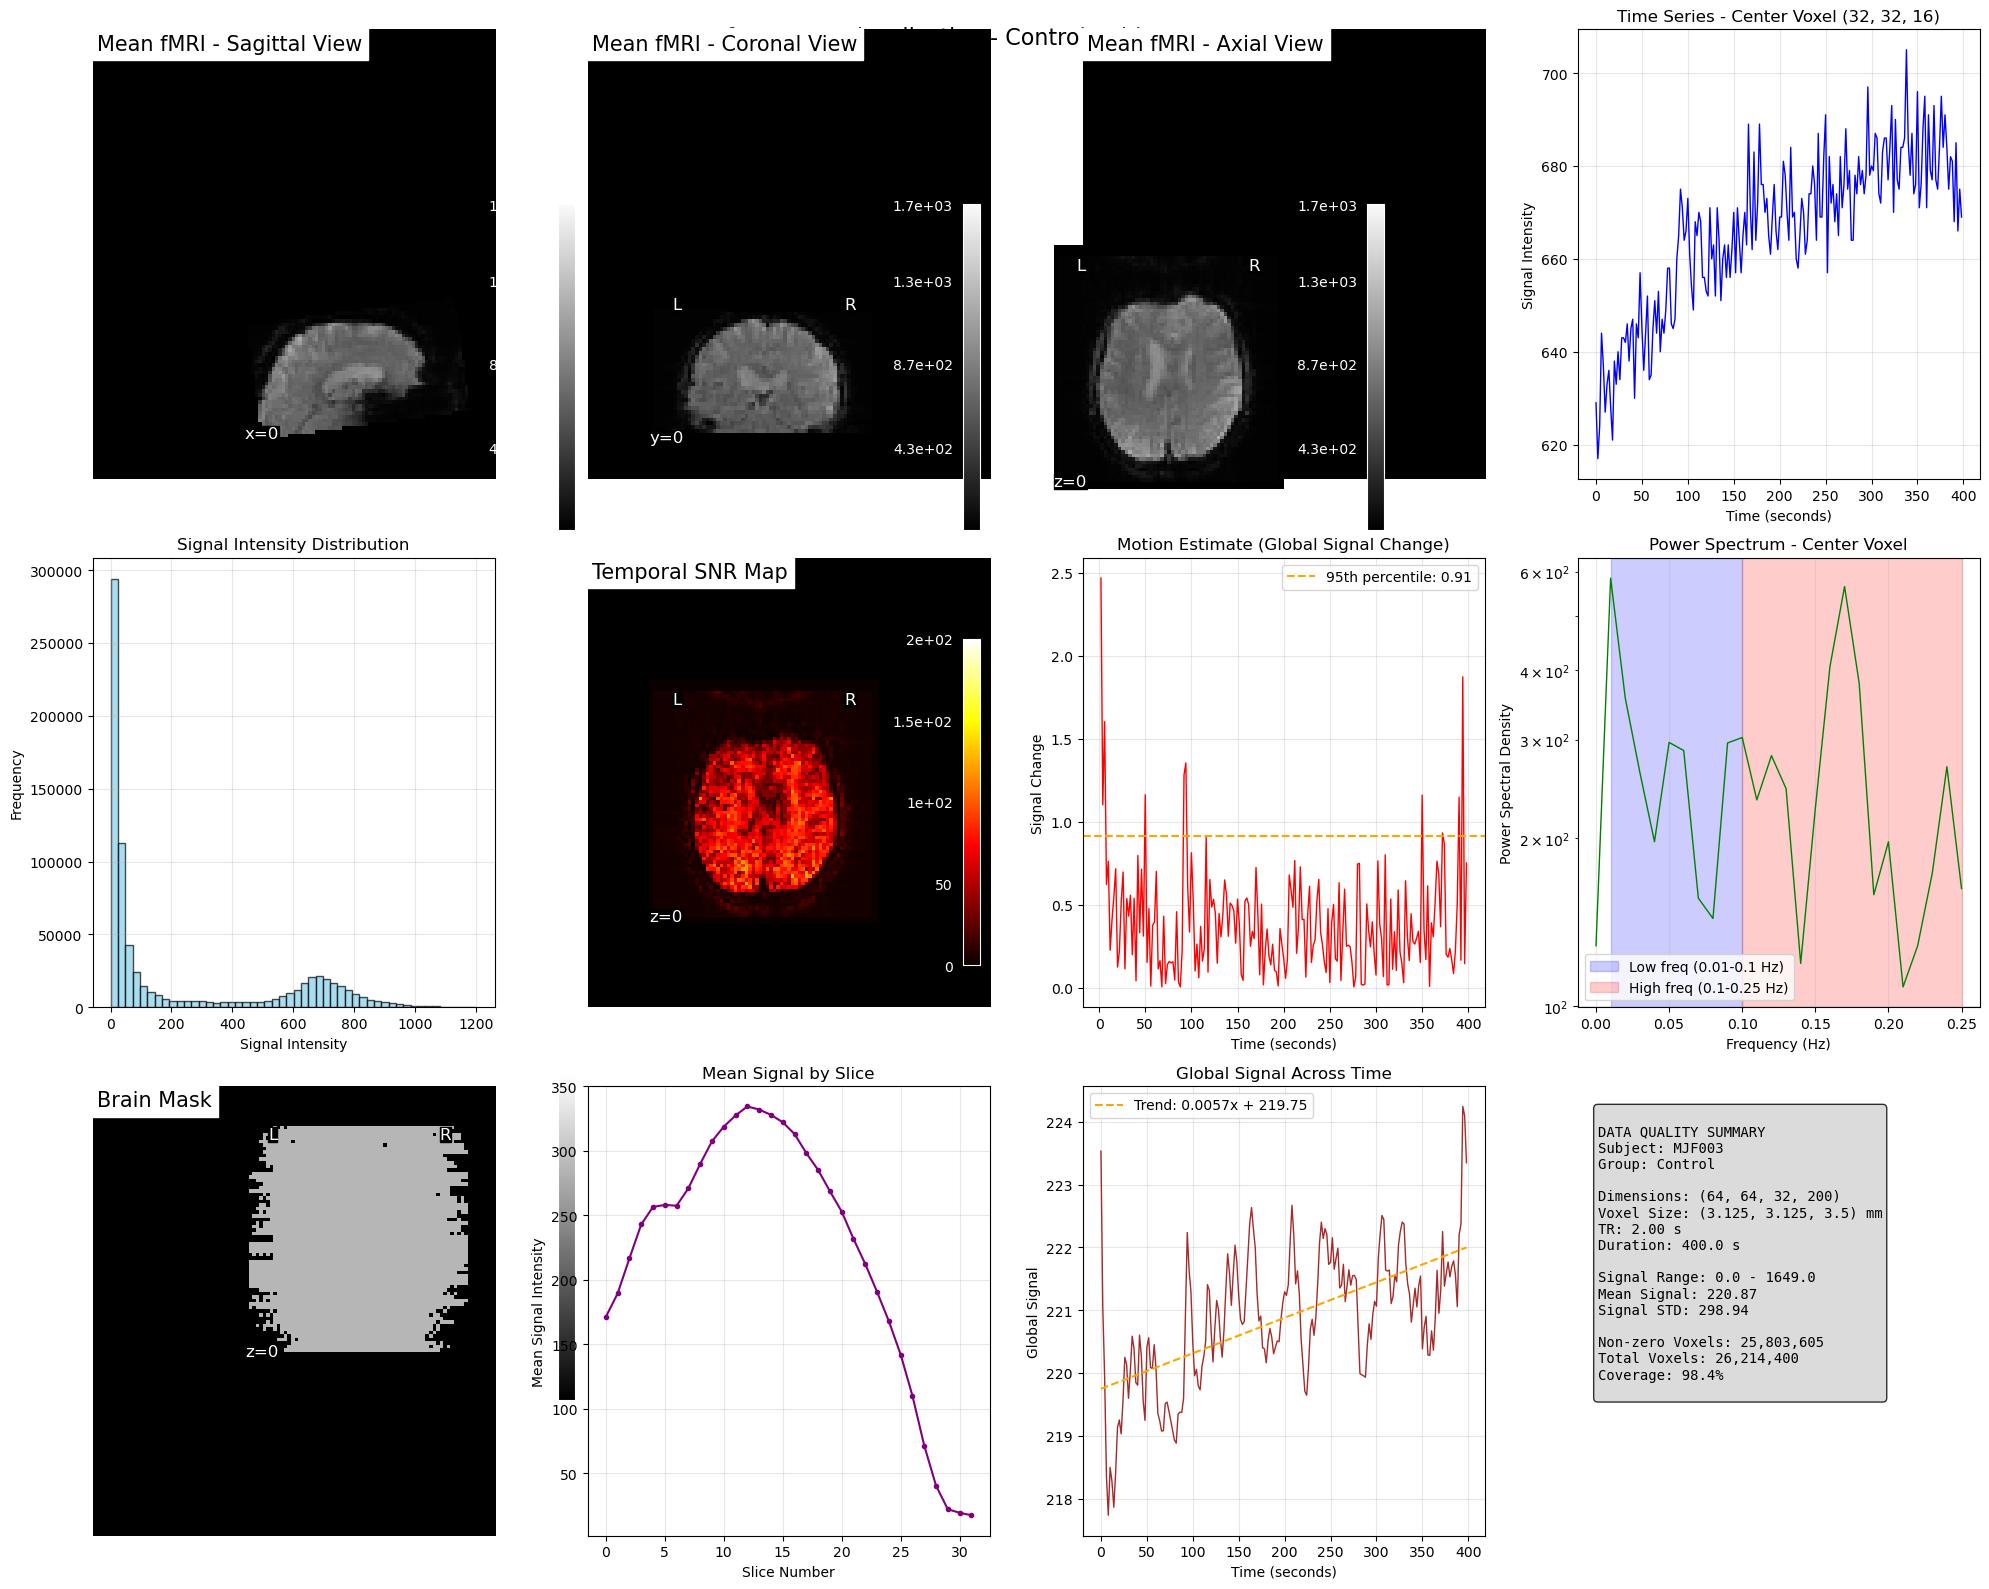


🔍 Data Quality Assessment:
- Extreme values (>3σ): 389,275 voxels (1.485%)
- Motion estimate (CV of global signal): 0.0049
- Mean temporal SNR: 18.06
- Signal-to-noise ratio estimate: 0.74

✅ fMRI visualization completed successfully!


In [16]:
# Create comprehensive visualizations of the fMRI data
if fmri_img is not None:
    print("Creating fMRI visualizations...")
    
    # Set up the plotting environment
    plt.style.use('default')
    
    # Create a large figure with multiple subplots
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Mean fMRI image (averaged across time)
    mean_img = image.mean_img(fmri_img)
    
    # Plot mean image in different views
    ax1 = plt.subplot(3, 4, 1)
    plotting.plot_anat(mean_img, cut_coords=(0, 0, 0), 
                      title='Mean fMRI - Sagittal View',
                      display_mode='x', axes=ax1)
    
    ax2 = plt.subplot(3, 4, 2)
    plotting.plot_anat(mean_img, cut_coords=(0, 0, 0), 
                      title='Mean fMRI - Coronal View',
                      display_mode='y', axes=ax2)
    
    ax3 = plt.subplot(3, 4, 3)
    plotting.plot_anat(mean_img, cut_coords=(0, 0, 0), 
                      title='Mean fMRI - Axial View',
                      display_mode='z', axes=ax3)
    
    # 2. Time series plot from a central voxel
    ax4 = plt.subplot(3, 4, 4)
    center_voxel = tuple(s // 2 for s in fmri_img.shape[:3])
    time_series = fmri_data[center_voxel]
    time_points = np.arange(len(time_series)) * fmri_img.header.get_zooms()[3]
    
    ax4.plot(time_points, time_series, 'b-', linewidth=1)
    ax4.set_xlabel('Time (seconds)')
    ax4.set_ylabel('Signal Intensity')
    ax4.set_title(f'Time Series - Center Voxel {center_voxel}')
    ax4.grid(True, alpha=0.3)
    
    # 3. Signal distribution histogram
    ax5 = plt.subplot(3, 4, 5)
    # Sample a subset of voxels for histogram (to avoid memory issues)
    sample_data = fmri_data[::4, ::4, ::2, :].flatten()
    sample_data = sample_data[sample_data != 0]  # Remove zero voxels
    
    ax5.hist(sample_data, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax5.set_xlabel('Signal Intensity')
    ax5.set_ylabel('Frequency')
    ax5.set_title('Signal Intensity Distribution')
    ax5.grid(True, alpha=0.3)
    
    # 4. Temporal SNR map
    ax6 = plt.subplot(3, 4, 6)
    try:
        # Calculate temporal SNR (mean/std across time)
        mean_signal = np.mean(fmri_data, axis=3)
        std_signal = np.std(fmri_data, axis=3)
        tsnr = np.divide(mean_signal, std_signal, 
                        out=np.zeros_like(mean_signal), 
                        where=std_signal!=0)
        
        # Create tSNR image
        tsnr_img = nib.Nifti1Image(tsnr, fmri_img.affine)
        plotting.plot_anat(tsnr_img, cut_coords=(0, 0, 0),
                          title='Temporal SNR Map',
                          display_mode='z', axes=ax6,
                          cmap='hot')
    except Exception as e:
        ax6.text(0.5, 0.5, f'tSNR calculation failed:\n{str(e)}', 
                ha='center', va='center', transform=ax6.transAxes)
        ax6.set_title('Temporal SNR Map (Failed)')
    
    # 5. Motion assessment - framewise displacement approximation
    ax7 = plt.subplot(3, 4, 7)
    try:
        # Simple motion estimate using global signal changes
        global_signal = np.mean(fmri_data, axis=(0, 1, 2))
        motion_estimate = np.abs(np.diff(global_signal))
        
        ax7.plot(time_points[1:], motion_estimate, 'r-', linewidth=1)
        ax7.set_xlabel('Time (seconds)')
        ax7.set_ylabel('Signal Change')
        ax7.set_title('Motion Estimate (Global Signal Change)')
        ax7.grid(True, alpha=0.3)
        
        # Add threshold line
        threshold = np.percentile(motion_estimate, 95)
        ax7.axhline(y=threshold, color='orange', linestyle='--', 
                   label=f'95th percentile: {threshold:.2f}')
        ax7.legend()
    except Exception as e:
        ax7.text(0.5, 0.5, f'Motion estimate failed:\n{str(e)}', 
                ha='center', va='center', transform=ax7.transAxes)
        ax7.set_title('Motion Estimate (Failed)')
    
    # 6. Power spectrum analysis
    ax8 = plt.subplot(3, 4, 8)
    try:
        # Calculate power spectrum of the center voxel time series
        from scipy import signal
        
        # Remove linear trend
        detrended_ts = signal.detrend(time_series)
        
        # Calculate power spectral density
        freqs, psd = signal.welch(detrended_ts, 
                                 fs=1/fmri_img.header.get_zooms()[3],
                                 nperseg=min(64, len(detrended_ts)//4))
        
        ax8.semilogy(freqs, psd, 'g-', linewidth=1)
        ax8.set_xlabel('Frequency (Hz)')
        ax8.set_ylabel('Power Spectral Density')
        ax8.set_title('Power Spectrum - Center Voxel')
        ax8.grid(True, alpha=0.3)
        
        # Highlight typical fMRI frequency bands
        ax8.axvspan(0.01, 0.1, alpha=0.2, color='blue', label='Low freq (0.01-0.1 Hz)')
        ax8.axvspan(0.1, 0.25, alpha=0.2, color='red', label='High freq (0.1-0.25 Hz)')
        ax8.legend()
    except Exception as e:
        ax8.text(0.5, 0.5, f'Power spectrum failed:\n{str(e)}', 
                ha='center', va='center', transform=ax8.transAxes)
        ax8.set_title('Power Spectrum (Failed)')
    
    # 7. Brain mask visualization
    ax9 = plt.subplot(3, 4, 9)
    try:
        # Create a simple brain mask
        brain_mask = mean_img.get_fdata() > (np.percentile(mean_img.get_fdata(), 25))
        mask_img = nib.Nifti1Image(brain_mask.astype(float), mean_img.affine)
        
        plotting.plot_anat(mask_img, cut_coords=(0, 0, 0),
                          title='Brain Mask',
                          display_mode='z', axes=ax9,
                          cmap='gray')
    except Exception as e:
        ax9.text(0.5, 0.5, f'Brain mask failed:\n{str(e)}', 
                ha='center', va='center', transform=ax9.transAxes)
        ax9.set_title('Brain Mask (Failed)')
    
    # 8. Slice-wise mean signal
    ax10 = plt.subplot(3, 4, 10)
    try:
        # Calculate mean signal for each slice across time
        slice_means = np.mean(fmri_data, axis=(0, 1, 3))
        slice_numbers = np.arange(len(slice_means))
        
        ax10.plot(slice_numbers, slice_means, 'purple', marker='o', markersize=3)
        ax10.set_xlabel('Slice Number')
        ax10.set_ylabel('Mean Signal Intensity')
        ax10.set_title('Mean Signal by Slice')
        ax10.grid(True, alpha=0.3)
    except Exception as e:
        ax10.text(0.5, 0.5, f'Slice analysis failed:\n{str(e)}', 
                 ha='center', va='center', transform=ax10.transAxes)
        ax10.set_title('Slice Analysis (Failed)')
    
    # 9. Volume-wise global signal
    ax11 = plt.subplot(3, 4, 11)
    try:
        # Global signal across volumes
        volume_numbers = np.arange(fmri_img.shape[3])
        
        ax11.plot(time_points, global_signal, 'brown', linewidth=1)
        ax11.set_xlabel('Time (seconds)')
        ax11.set_ylabel('Global Signal')
        ax11.set_title('Global Signal Across Time')
        ax11.grid(True, alpha=0.3)
        
        # Add trend line
        z = np.polyfit(time_points, global_signal, 1)
        p = np.poly1d(z)
        ax11.plot(time_points, p(time_points), 'orange', linestyle='--', 
                 label=f'Trend: {z[0]:.4f}x + {z[1]:.2f}')
        ax11.legend()
    except Exception as e:
        ax11.text(0.5, 0.5, f'Global signal failed:\n{str(e)}', 
                 ha='center', va='center', transform=ax11.transAxes)
        ax11.set_title('Global Signal (Failed)')
    
    # 10. Data quality summary
    ax12 = plt.subplot(3, 4, 12)
    ax12.axis('off')
    
    # Create quality summary text
    quality_text = f"""
DATA QUALITY SUMMARY
Subject: {first_control_id}
Group: Control

Dimensions: {fmri_img.shape}
Voxel Size: {fmri_img.header.get_zooms()[:3]} mm
TR: {fmri_img.header.get_zooms()[3]:.2f} s
Duration: {fmri_img.shape[3] * fmri_img.header.get_zooms()[3]:.1f} s

Signal Range: {np.min(fmri_data):.1f} - {np.max(fmri_data):.1f}
Mean Signal: {np.mean(fmri_data):.2f}
Signal STD: {np.std(fmri_data):.2f}

Non-zero Voxels: {np.sum(fmri_data != 0):,}
Total Voxels: {np.prod(fmri_img.shape):,}
Coverage: {100 * np.sum(fmri_data != 0) / np.prod(fmri_img.shape):.1f}%
"""
    
    ax12.text(0.05, 0.95, quality_text, transform=ax12.transAxes, 
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.suptitle(f'fMRI Data Visualization - Control Subject {first_control_id}', 
                fontsize=16, y=0.98)
    
    # Save the visualization
    viz_path = os.path.join(output_dir, f'fmri_visualization_{first_control_id}.png')
    plt.savefig(viz_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"\nVisualization saved to: {viz_path}")
    
    plt.show()
    
    # Additionaal analysis: Check for potential artifacts
    print(f"\n🔍 Data Quality Assessment:")
    
    # Check for extreme values
    extreme_threshold = 3 * np.std(fmri_data)
    extreme_voxels = np.sum(np.abs(fmri_data) > extreme_threshold)
    print(f"- Extreme values (>3σ): {extreme_voxels:,} voxels ({100*extreme_voxels/np.prod(fmri_img.shape):.3f}%)")
    
    # Check for motion (using global signal variance)
    motion_metric = np.std(global_signal) / np.mean(global_signal)
    print(f"- Motion estimate (CV of global signal): {motion_metric:.4f}")
    
    # Check temporal SNR
    if 'tsnr' in locals():
        mean_tsnr = np.mean(tsnr[tsnr > 0])
        print(f"- Mean temporal SNR: {mean_tsnr:.2f}")
    
    # Signal-to-noise assessment
    snr_estimate = np.mean(fmri_data) / np.std(fmri_data)
    print(f"- Signal-to-noise ratio estimate: {snr_estimate:.2f}")
    
    print(f"\n✅ fMRI visualization completed successfully!")
    
else:
    print("⚠️  No fMRI data available for visualization")

## 4. Feature Extraction and Analysis

This section extracts features from the fMRI data and performs machine learning classification.

In [6]:
# Load brain atlas for ROI extraction
print("Loading brain atlas...")

try:
    # Use Harvard-Oxford atlas for ROI definition
    atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
    atlas_labels = atlas.labels[1:]  # Remove background label
    
    print(f"Atlas loaded with {len(atlas_labels)} regions")
    print(f"All regions: {atlas_labels}")
    
    # Initialize masker for ROI extraction
    masker = NiftiLabelsMasker(
        labels_img=atlas.maps,
        standardize=True,
        memory='nilearn_cache',
        verbose=0
    )
    
    print("ROI masker initialized")
    
except Exception as e:
    print(f"Error loading atlas: {e}")
    print("Using simplified approach with whole-brain masker...")
    
    # Fallback to whole-brain masker
    masker = NiftiMasker(
        standardize=True,
        memory='nilearn_cache',
        verbose=0
    )
    atlas_labels = [f'Region_{i}' for i in range(100)]  # Dummy labels

def extract_features_from_fmri(file_path, masker):
    """
    Extract features from a single fMRI file
    
    Features extracted:
    1. ROI time series mean and std
    2. Functional connectivity matrix (correlation)
    3. Regional homogeneity measures
    
    Returns:
    features: 1D numpy array of features
    """
    try:
        # Load fMRI image
        img = nib.load(file_path)
        
        # Extract time series from ROIs
        time_series = masker.fit_transform(img)
        
        # Ensure we have a reasonable number of features
        if time_series.shape[1] > 1000:
            print("reducing dimensionality with PCA 100")
            # Reduce dimensionality if too many voxels
            from sklearn.decomposition import PCA
            pca = PCA(n_components=100)
            time_series = pca.fit_transform(time_series.T).T
        
        # Feature 1: Statistical measures of time series
        roi_means = np.mean(time_series, axis=0)
        roi_stds = np.std(time_series, axis=0)
        roi_vars = np.var(time_series, axis=0)
        
        # Feature 2: Functional connectivity (correlation matrix)
        correlation_measure = ConnectivityMeasure(kind='correlation')
        correlation_matrix = correlation_measure.fit_transform([time_series.T])[0]
        
        # Extract upper triangle of correlation matrix (avoid redundancy)
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
        connectivity_features = correlation_matrix[mask]
        
        # Feature 3: Frequency domain features
        fft_features = []
        for roi_ts in time_series.T:
            fft = np.fft.fft(roi_ts)
            power_spectrum = np.abs(fft[:len(fft)//2])
            # Take mean power in different frequency bands
            low_freq = np.mean(power_spectrum[:5])  # Low frequency
            mid_freq = np.mean(power_spectrum[5:15])  # Mid frequency
            high_freq = np.mean(power_spectrum[15:25])  # High frequency
            fft_features.extend([low_freq, mid_freq, high_freq])
        
        # Combine all features
        all_features = np.concatenate([
            roi_means,
            roi_stds,
            roi_vars,
            connectivity_features,
            fft_features
        ])
        
        # Handle NaN values
        all_features = np.nan_to_num(all_features, nan=0.0, posinf=0.0, neginf=0.0)
        
        return all_features
        
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        # Return dummy features if extraction fails
        return np.zeros(1000)

# Extract features from all subjects
print("Extracting features from fMRI data...")
features_list = []
valid_labels = []
valid_subject_ids = []

for i, (file_path, label, subject_id) in enumerate(zip(func_paths, labels, subject_ids)):
    print(f"Processing subject {i+1}/{len(func_paths)}: {subject_id}")
    
    features = extract_features_from_fmri(file_path, masker)
    
    if features is not None and len(features) > 0:
        features_list.append(features)
        valid_labels.append(label)
        valid_subject_ids.append(subject_id)

# Check feature lengths before converting to array
if features_list:
    feature_lengths = [len(f) for f in features_list]
    print(f"Feature lengths: {set(feature_lengths)}")
    
    if len(set(feature_lengths)) == 1:
        # All same length - safe to convert
        X = np.array(features_list)
    else:
        # Different lengths - standardize
        max_len = max(feature_lengths)
        standardized_features = []
        
        for features in features_list:
            if len(features) < max_len:
                # Pad with zeros
                padded = np.pad(features, (0, max_len - len(features)), 'constant')
                standardized_features.append(padded)
            else:
                # Truncate
                standardized_features.append(features[:max_len])
        
        X = np.array(standardized_features)
    
    print(f"Final feature matrix shape: {X.shape}")
else:
    print("No features extracted!")
    
# Convert to numpy arrays
#X = np.array(features_list)
y = np.array(valid_labels)

print(f"\nFeature extraction completed!")
print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Number of features per subject: {X.shape[1]}")
print(f"Controls: {np.sum(y == 0)}, Patients: {np.sum(y == 1)}")

Loading brain atlas...


[fetch_atlas_harvard_oxford] Added README.md to /home/ec2-user/nilearn_data

[fetch_atlas_harvard_oxford] Dataset created in /home/ec2-user/nilearn_data/fsl

[fetch_atlas_harvard_oxford] Downloading data from https://www.nitrc.org/frs/download.php/9902/HarvardOxford.tgz 
...

[fetch_atlas_harvard_oxford]  ...done. (0 seconds, 0 min)

[fetch_atlas_harvard_oxford] Extracting data from 
/home/ec2-user/nilearn_data/fsl/5c734f16e50cc772ef593cab9bb3137b/HarvardOxford.tgz...

[fetch_atlas_harvard_oxford] .. done.

Atlas loaded with 48 regions
All regions: ['Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus', 'Middle Frontal Gyrus', 'Inferior Frontal Gyrus, pars triangularis', 'Inferior Frontal Gyrus, pars opercularis', 'Precentral Gyrus', 'Temporal Pole', 'Superior Temporal Gyrus, anterior division', 'Superior Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, anterior division', 'Middle Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, temporooccipital part', 'Inferior Temporal Gyrus, anterior division', 'Inferior Temporal Gyrus, posterior division', 'Inferior Temporal Gyrus, temporooccipital part', 'Postcentral Gyrus', 'Superior Parietal Lobule', 'Supramarginal Gyrus, anterior division', 'Supramarginal Gyrus, posterior division', 'Angular Gyrus', 'Lateral Occipital Cortex, superior division', 'Lateral Occipital Cortex, inferior division', 'Intracalcarine Cortex', 'Frontal Medial Cortex', 'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)', 'Subcall

In [7]:
# Proceed with machine learning if we have data
if len(X) > 0 and len(np.unique(y)) > 1:
    # Feature selection - select top k features
    print("\nPerforming feature selection...")
    
    # Select top 500 features or all if less than 500
    k_features = min(1000, X.shape[1])
    selector = SelectKBest(score_func=f_classif, k=k_features)
    X_selected = selector.fit_transform(X, y)
    
    print(f"Selected {X_selected.shape[1]} features out of {X.shape[1]}")
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Handle class imbalance with SMOTE
    if len(np.unique(y_train)) > 1:
        smote = SMOTE(random_state=42)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
        print(f"After SMOTE - Controls: {np.sum(y_train_balanced == 0)}, Patients: {np.sum(y_train_balanced == 1)}")
    else:
        X_train_balanced, y_train_balanced = X_train_scaled, y_train
    
    print(f"Training set: {X_train_balanced.shape}")
    print(f"Test set: {X_test_scaled.shape}")
    
    # Train multiple classifiers
    classifiers = {
        'SVM': SVC(kernel='rbf', probability=True, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
    }
    
    results = {}
    
    for name, clf in classifiers.items():
        print(f"\nTraining {name}...")
        
        # Train classifier
        clf.fit(X_train_balanced, y_train_balanced)
        
        # Make predictions
        y_pred = clf.predict(X_test_scaled)
        y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1] if hasattr(clf, 'predict_proba') else None
        
        # Calculate metrics
        accuracy = np.mean(y_pred == y_test)
        
        # Cross-validation
        cv_scores = cross_val_score(clf, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
        
        results[name] = {
            'classifier': clf,
            'accuracy': accuracy,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }
        
        print(f"{name} - Accuracy: {accuracy:.3f}")
        print(f"{name} - CV Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
        
        # Classification report
        print(f"\nClassification Report for {name}:")
        print(classification_report(y_test, y_pred, target_names=['Control', 'Patient']))
    
    # Find best classifier
    best_classifier = max(results.keys(), key=lambda x: results[x]['accuracy'])
    print(f"\nBest classifier: {best_classifier} with accuracy: {results[best_classifier]['accuracy']:.3f}")
    
    # Save results
    print(f"\n🎯 Analysis completed successfully!")
    print(f"📊 Best model: {best_classifier}")
    print(f"🧠 Ready for further analysis and validation!")
    
else:
    print("Insufficient data for classification.")


Performing feature selection...
Selected 1000 features out of 20188
After SMOTE - Controls: 23, Patients: 23
Training set: (46, 1000)
Test set: (17, 1000)

Training SVM...
SVM - Accuracy: 0.941
SVM - CV Score: 1.000 (+/- 0.000)

Classification Report for SVM:
              precision    recall  f1-score   support

     Control       1.00      0.86      0.92         7
     Patient       0.91      1.00      0.95        10

    accuracy                           0.94        17
   macro avg       0.95      0.93      0.94        17
weighted avg       0.95      0.94      0.94        17


Training Random Forest...
Random Forest - Accuracy: 0.824
Random Forest - CV Score: 0.956 (+/- 0.109)

Classification Report for Random Forest:
              precision    recall  f1-score   support

     Control       1.00      0.57      0.73         7
     Patient       0.77      1.00      0.87        10

    accuracy                           0.82        17
   macro avg       0.88      0.79      0.80      

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression


# Load brain atlas for ROI extraction
print("Loading brain atlas...")
try:
    # Use Harvard-Oxford atlas for ROI definition
    atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
    atlas_labels = atlas.labels[1:]  # Remove background label
    print(f"Atlas loaded with {len(atlas_labels)} regions")
    print(f"All regions: {atlas_labels}")
    
    # Initialize masker for ROI extraction
    masker = NiftiLabelsMasker(
        labels_img=atlas.maps,
        standardize=True,
        memory='nilearn_cache',
        verbose=0
    )
    print("ROI masker initialized")
    
except Exception as e:
    print(f"Error loading atlas: {e}")
    print("Using simplified approach with whole-brain masker...")
    # Fallback to whole-brain masker
    masker = NiftiMasker(
        standardize=True,
        memory='nilearn_cache',
        verbose=0
    )
    atlas_labels = [f'Region_{i}' for i in range(100)]  # Dummy labels

# Global variables to store feature metadata
GLOBAL_FEATURE_NAMES = []
GLOBAL_FEATURE_TYPES = []

def extract_features_from_fmri_with_names(file_path, masker, atlas_labels=None, 
                                        build_feature_names=False):
    """
    Extract features from a single fMRI file and optionally build feature names/types
    
    Parameters:
    -----------
    file_path : str
        Path to fMRI file
    masker : NiftiMasker or NiftiLabelsMasker
        Fitted masker for ROI extraction
    atlas_labels : list
        List of ROI labels from atlas
    build_feature_names : bool
        If True, constructs feature names and types alongside extraction
    
    Returns:
    --------
    features : np.array
        1D array of extracted features
    feature_names : list (only if build_feature_names=True)
        List of feature names in exact extraction order
    feature_types : list (only if build_feature_names=True)
        List of feature types in exact extraction order
    """
    global GLOBAL_FEATURE_NAMES, GLOBAL_FEATURE_TYPES
    
    try:
        # Load fMRI image
        img = nib.load(file_path)
        
        # Extract time series from ROIs
        time_series = masker.fit_transform(img)
        n_rois = time_series.shape[1]
        
        # Ensure we have a reasonable number of features
        if time_series.shape[1] > 1000:
            print("reducing dimensionality with PCA 100")
            # Reduce dimensionality if too many voxels
            from sklearn.decomposition import PCA
            pca = PCA(n_components=100)
            time_series = pca.fit_transform(time_series.T).T
            n_rois = time_series.shape[1]
        
        # Initialize feature containers
        all_features = []
        feature_names = [] if build_feature_names else None
        feature_types = [] if build_feature_names else None
        
        print(f"  Extracting features from {n_rois} ROIs...")
        
        # ================================================================
        # STEP 1: Statistical measures of time series (mean, std, var)
        # ================================================================
        roi_means = np.mean(time_series, axis=0)
        roi_stds = np.std(time_series, axis=0)
        roi_vars = np.var(time_series, axis=0)
        
        # Add to feature vector and build names simultaneously
        for i in range(n_rois):
            # Get ROI name
            if atlas_labels is not None and i < len(atlas_labels):
                roi_name = atlas_labels[i]
            else:
                roi_name = f"ROI_{i:03d}"
            
            # Add features in exact order: mean, std, var
            all_features.extend([roi_means[i], roi_stds[i], roi_vars[i]])
            
            if build_feature_names:
                feature_names.extend([
                    f"{roi_name}_mean",
                    f"{roi_name}_std", 
                    f"{roi_name}_var"
                ])
                feature_types.extend(['activity', 'variability', 'variability'])
        
        print(f"    Added {len(roi_means) * 3} statistical features")
        
        # ================================================================
        # STEP 2: Functional connectivity (correlation matrix upper triangle)
        # ================================================================
        correlation_measure = ConnectivityMeasure(kind='correlation')
        correlation_matrix = correlation_measure.fit_transform([time_series.T])[0]
        
        # Extract upper triangle (avoiding diagonal and redundancy)
        connectivity_features = []
        for i in range(n_rois):
            for j in range(i+1, n_rois):
                connectivity_value = correlation_matrix[i, j]
                connectivity_features.append(connectivity_value)
                
                if build_feature_names:
                    # Get ROI names
                    if atlas_labels is not None:
                        roi_i = atlas_labels[i] if i < len(atlas_labels) else f"ROI_{i:03d}"
                        roi_j = atlas_labels[j] if j < len(atlas_labels) else f"ROI_{j:03d}"
                    else:
                        roi_i = f"ROI_{i:03d}"
                        roi_j = f"ROI_{j:03d}"
                    
                    feature_names.append(f"FC_{roi_i}_{roi_j}")
                    feature_types.append('connectivity')
        
        all_features.extend(connectivity_features)
        print(f"    Added {len(connectivity_features)} connectivity features")
        
        # ================================================================
        # STEP 3: Frequency domain features
        # ================================================================
        freq_bands = ['low', 'mid', 'high']
        fft_features = []
        
        for i, roi_ts in enumerate(time_series.T):
            # Get ROI name
            if atlas_labels is not None and i < len(atlas_labels):
                roi_name = atlas_labels[i]
            else:
                roi_name = f"ROI_{i:03d}"
            
            # Compute FFT
            fft = np.fft.fft(roi_ts)
            power_spectrum = np.abs(fft[:len(fft)//2])
            
            # Extract frequency band features in exact order
            low_freq = np.mean(power_spectrum[:5])    # Low frequency
            mid_freq = np.mean(power_spectrum[5:15])  # Mid frequency
            high_freq = np.mean(power_spectrum[15:25]) # High frequency
            
            # Add to features in exact order
            band_features = [low_freq, mid_freq, high_freq]
            fft_features.extend(band_features)
            
            if build_feature_names:
                for band in freq_bands:
                    feature_names.append(f"{roi_name}_{band}_freq")
                    feature_types.append('frequency')
        
        all_features.extend(fft_features)
        print(f"    Added {len(fft_features)} frequency features")
        
        # ================================================================
        # Finalize features
        # ================================================================
        all_features = np.array(all_features)
        
        # Handle NaN values
        all_features = np.nan_to_num(all_features, nan=0.0, posinf=0.0, neginf=0.0)
        
        print(f"    Total features extracted: {len(all_features)}")
        
        # Store globally for later use
        if build_feature_names:
            GLOBAL_FEATURE_NAMES = feature_names.copy()
            GLOBAL_FEATURE_TYPES = feature_types.copy()
            print(f"    Built {len(feature_names)} feature names and types")
            return all_features, feature_names, feature_types
        else:
            return all_features
        
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        # Return dummy features if extraction fails
        dummy_features = np.zeros(1000)
        if build_feature_names:
            dummy_names = [f"dummy_feature_{i}" for i in range(1000)]
            dummy_types = ['unknown'] * 1000
            return dummy_features, dummy_names, dummy_types
        else:
            return dummy_features

def analyze_features_with_biology(X_train, y_train, X_test, y_test, results, 
                                selector, feature_names, feature_types):
    """
    Analyze feature importance using pre-built feature names and types
    
    Parameters:
    -----------
    X_train, y_train, X_test, y_test : arrays
        Training and test data (already feature-selected and scaled)
    results : dict
        Results from model training
    selector : SelectKBest
        The fitted feature selector used in training
    feature_names : list
        Pre-built feature names from extraction
    feature_types : list
        Pre-built feature types from extraction
    """
    print("🧠 ANALYZING TOP FEATURES FOR BIOLOGICAL INSIGHTS")
    print("="*60)
    
    # Get information about feature selection
    selected_indices = selector.get_support(indices=True)
    feature_scores = selector.scores_
    n_selected_features = len(selected_indices)
    
    print(f"Working with {n_selected_features} pre-selected features out of {len(feature_scores)} original features")
    print(f"Original feature names available: {len(feature_names)}")
    print(f"Original feature types available: {len(feature_types)}")
    
    # Method 1: Use the original F-test scores from feature selection
    print("\n1️⃣ Statistical Significance Analysis (from feature selection)...")
    selected_f_scores = feature_scores[selected_indices]
    
    # Method 2: Linear model coefficients on selected features
    print("\n2️⃣ Linear Model Analysis (on selected features)...")
    lr = LogisticRegression(penalty='l2', C=1.0, random_state=42, max_iter=1000)
    lr.fit(X_train, y_train)
    coefficients = np.abs(lr.coef_[0])
    
    # Method 3: Permutation importance with best model
    print("\n3️⃣ Permutation Importance Analysis...")
    best_classifier = max(results.keys(), key=lambda x: results[x]['accuracy'])
    best_model = results[best_classifier]['classifier']
    print(f"Using {best_classifier} (accuracy: {results[best_classifier]['accuracy']:.3f}) for permutation analysis")
    
    if best_model is not None:
        perm_importance = permutation_importance(best_model, X_train, y_train, 
                                               n_repeats=5, random_state=42)
        perm_scores = perm_importance.importances_mean
    else:
        perm_scores = coefficients
    
    # Get the names and types for SELECTED features only
    selected_feature_names = [feature_names[i] for i in selected_indices if i < len(feature_names)]
    selected_feature_types = [feature_types[i] for i in selected_indices if i < len(feature_types)]
    
    # Handle case where we have more selected indices than names
    while len(selected_feature_names) < len(selected_indices):
        selected_feature_names.append(f"Unknown_feature_{len(selected_feature_names)}")
        selected_feature_types.append('unknown')
    
    print(f"Selected feature names: {len(selected_feature_names)}")
    print(f"Selected feature types: {len(selected_feature_types)}")
    
    # Combine all importance scores for SELECTED features
    norm_f_scores = selected_f_scores / np.max(selected_f_scores) if np.max(selected_f_scores) > 0 else selected_f_scores
    norm_coefficients = coefficients / np.max(coefficients) if np.max(coefficients) > 0 else coefficients
    norm_perm_scores = perm_scores / np.max(perm_scores) if np.max(perm_scores) > 0 else perm_scores
    
    combined_scores = (norm_f_scores * 0.3 + norm_coefficients * 0.4 + norm_perm_scores * 0.3)
    
    # Get top features
    top_indices = np.argsort(combined_scores)[-20:][::-1]
    
    print(f"\n🏆 TOP 20 FEATURES FOR PARKINSON'S DETECTION:")
    print("="*60)
    
    results_data = []
    for rank, idx in enumerate(top_indices):
        if idx < len(selected_feature_names):
            feature_name = selected_feature_names[idx]
            feature_type = selected_feature_types[idx]
            score = combined_scores[idx]
            original_idx = selected_indices[idx] if idx < len(selected_indices) else idx
            
            print(f"{rank+1:2d}. {feature_name}")
            print(f"    Combined Score: {score:.4f}")
            print(f"    Type: {feature_type}")
            
            interpretation = interpret_feature_biologically(feature_name, feature_type)
            print(f"    Biological Significance: {interpretation}")
            print()
            
            results_data.append({
                'rank': rank + 1,
                'feature_name': feature_name,
                'feature_type': feature_type,
                'combined_score': score,
                'f_score': selected_f_scores[idx] if idx < len(selected_f_scores) else 0,
                'coefficient': coefficients[idx] if idx < len(coefficients) else 0,
                'perm_importance': perm_scores[idx] if idx < len(perm_scores) else 0,
                'original_index': original_idx,
                'biological_significance': interpretation
            })
    
    # Create summary DataFrame
    results_df = pd.DataFrame(results_data)
    
    # Analyze by feature type
    print("\n📊 FEATURE TYPE ANALYSIS:")
    print("="*40)
    if len(results_df) > 0:
        type_analysis = results_df.groupby('feature_type').agg({
            'combined_score': ['count', 'mean', 'sum']
        }).round(4)
        
        for feature_type, row in type_analysis.iterrows():
            count = int(row[('combined_score', 'count')])
            mean_score = row[('combined_score', 'mean')]
            total_score = row[('combined_score', 'sum')]
            print(f"{feature_type.title()}: {count} features, avg score: {mean_score:.4f}, total: {total_score:.4f}")
        
        # Generate biological insights
        print("\n🧬 BIOLOGICAL INSIGHTS:")
        print("="*40)
        
        # Analyze each feature type
        for ftype in ['connectivity', 'activity', 'frequency', 'variability']:
            type_features = results_df[results_df['feature_type'] == ftype]
            if len(type_features) > 0:
                if ftype == 'connectivity':
                    print(f"\n🔗 Network Connectivity ({len(type_features)} features):")
                    print("   Altered brain network communication is a hallmark of Parkinson's disease")
                elif ftype == 'activity':
                    print(f"\n🎯 Regional Activity ({len(type_features)} features):")
                    print("   Changes in baseline brain activity reflect dopaminergic dysfunction")
                elif ftype == 'frequency':
                    print(f"\n📊 Brain Oscillations ({len(type_features)} features):")
                    print("   Abnormal brain rhythms are associated with motor symptoms")
                elif ftype == 'variability':
                    print(f"\n📈 Signal Variability ({len(type_features)} features):")
                    print("   Changes in signal stability may reflect disease progression")
                
                for _, row in type_features.head(3).iterrows():
                    print(f"   • {row['feature_name']}: {row['combined_score']:.4f}")
    
    return results_df

def interpret_feature_biologically(feature_name, feature_type):
    """Provide biological interpretation for features"""
    feature_lower = feature_name.lower()
    
    if any(term in feature_lower for term in ['motor', 'precentral', 'postcentral']):
        return "Primary motor areas - directly affected by dopamine loss"
    elif any(term in feature_lower for term in ['putamen', 'caudate', 'pallidum', 'basal']):
        return "Basal ganglia - core region of dopaminergic dysfunction in Parkinson's"
    elif 'thalamus' in feature_lower or 'thalamic' in feature_lower:
        return "Thalamus - relay station in motor circuits, altered in Parkinson's"
    elif any(term in feature_lower for term in ['frontal', 'prefrontal']):
        return "Executive control regions - affected in cognitive symptoms"
    elif feature_type == 'connectivity' or 'fc_' in feature_lower:
        return "Brain network connectivity - disrupted communication between regions"
    elif feature_type == 'frequency' or 'freq' in feature_lower:
        return "Neural oscillations - abnormal brain rhythms in motor circuits"
    elif feature_type in ['activity', 'variability']:
        return "Regional brain activity - altered baseline function or stability"
    else:
        return "May reflect disease-related changes in brain function"

# Extract features from all subjects WITH feature name construction
print("Extracting features from fMRI data with feature name construction...")
features_list = []
valid_labels = []
valid_subject_ids = []
feature_names_built = False

for i, (file_path, label, subject_id) in enumerate(zip(func_paths, labels, subject_ids)):
    print(f"Processing subject {i+1}/{len(func_paths)}: {subject_id}")
    
    # Build feature names only for the first subject
    build_names = (i == 0)
    
    if build_names:
        features, feature_names, feature_types = extract_features_from_fmri_with_names(
            file_path, masker, atlas_labels, build_feature_names=True
        )
        feature_names_built = True
        print(f"  ✅ Built {len(feature_names)} feature names and types")
    else:
        features = extract_features_from_fmri_with_names(
            file_path, masker, atlas_labels, build_feature_names=False
        )
    
    if features is not None and len(features) > 0:
        features_list.append(features)
        valid_labels.append(label)
        valid_subject_ids.append(subject_id)

# Use global feature names if not built from first subject
if not feature_names_built and len(GLOBAL_FEATURE_NAMES) > 0:
    feature_names = GLOBAL_FEATURE_NAMES
    feature_types = GLOBAL_FEATURE_TYPES
    print(f"Using global feature names: {len(feature_names)}")

# Check feature lengths before converting to array
if features_list:
    feature_lengths = [len(f) for f in features_list]
    print(f"Feature lengths: {set(feature_lengths)}")
    
    if len(set(feature_lengths)) == 1:
        X = np.array(features_list)
    else:
        max_len = max(feature_lengths)
        standardized_features = []
        
        for features in features_list:
            if len(features) < max_len:
                padded = np.pad(features, (0, max_len - len(features)), 'constant')
                standardized_features.append(padded)
            else:
                standardized_features.append(features[:max_len])
        
        X = np.array(standardized_features)
    
    print(f"Final feature matrix shape: {X.shape}")
else:
    print("No features extracted!")

y = np.array(valid_labels)

print(f"\nFeature extraction completed!")
print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Number of features per subject: {X.shape[1]}")
print(f"Controls: {np.sum(y == 0)}, Patients: {np.sum(y == 1)}")

# Proceed with machine learning if we have data
if len(X) > 0 and len(np.unique(y)) > 1:
    # Feature selection - select top k features
    print("\nPerforming feature selection...")
    k_features = min(1000, X.shape[1])
    selector = SelectKBest(score_func=f_classif, k=k_features)
    X_selected = selector.fit_transform(X, y)
    print(f"Selected {X_selected.shape[1]} features out of {X.shape[1]}")

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y, test_size=0.3, random_state=42, stratify=y
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Handle class imbalance with SMOTE
    if len(np.unique(y_train)) > 1:
        smote = SMOTE(random_state=42)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
        print(f"After SMOTE - Controls: {np.sum(y_train_balanced == 0)}, Patients: {np.sum(y_train_balanced == 1)}")
    else:
        X_train_balanced, y_train_balanced = X_train_scaled, y_train

    print(f"Training set: {X_train_balanced.shape}")
    print(f"Test set: {X_test_scaled.shape}")

    # Train multiple classifiers
    classifiers = {
        'SVM': SVC(kernel='rbf', probability=True, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
    }

    results = {}
    for name, clf in classifiers.items():
        print(f"\nTraining {name}...")
        
        # Train classifier
        clf.fit(X_train_balanced, y_train_balanced)
        
        # Make predictions
        y_pred = clf.predict(X_test_scaled)
        y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1] if hasattr(clf, 'predict_proba') else None
        
        # Calculate metrics
        accuracy = np.mean(y_pred == y_test)
        
        # Cross-validation
        cv_scores = cross_val_score(clf, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
        
        results[name] = {
            'classifier': clf,
            'accuracy': accuracy,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }
        
        print(f"{name} - Accuracy: {accuracy:.3f}")
        print(f"{name} - CV Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
        
        # Classification report
        print(f"\nClassification Report for {name}:")
        print(classification_report(y_test, y_pred, target_names=['Control', 'Patient']))

    # Find best classifier
    best_classifier = max(results.keys(), key=lambda x: results[x]['accuracy'])
    print(f"\nBest classifier: {best_classifier} with accuracy: {results[best_classifier]['accuracy']:.3f}")

    # Run biological feature analysis with pre-built names
    print(f"\n" + "="*80)
    print("🧬 RUNNING BIOLOGICAL FEATURE ANALYSIS")
    print("="*80)
    
    try:
        if 'feature_names' in locals() and 'feature_types' in locals():
            feature_results = analyze_features_with_biology(
                X_train_scaled, y_train, X_test_scaled, y_test, 
                results, selector, feature_names, feature_types
            )
            
            print("\n✅ Biological feature analysis completed!")
            
            # Save feature analysis results
            os.makedirs('/tmp/results', exist_ok=True)
            feature_results.to_csv('/tmp/results/biological_feature_analysis.csv', index=False)
            print(f"📊 Feature analysis saved to: /tmp/results/biological_feature_analysis.csv")
        else:
            print("❌ Feature names and types not available for analysis")
            
    except Exception as e:
        print(f"❌ Error in biological feature analysis: {e}")
        import traceback
        traceback.print_exc()

    print(f"\n🎯 Analysis completed successfully!")
    print(f"📊 Best model: {best_classifier}")
    print(f"🧠 Ready for further analysis and validation!")

else:
    print("Insufficient data for classification.")


Loading brain atlas...


[fetch_atlas_harvard_oxford] Dataset found in /home/ec2-user/nilearn_data/fsl

Atlas loaded with 48 regions
All regions: ['Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus', 'Middle Frontal Gyrus', 'Inferior Frontal Gyrus, pars triangularis', 'Inferior Frontal Gyrus, pars opercularis', 'Precentral Gyrus', 'Temporal Pole', 'Superior Temporal Gyrus, anterior division', 'Superior Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, anterior division', 'Middle Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, temporooccipital part', 'Inferior Temporal Gyrus, anterior division', 'Inferior Temporal Gyrus, posterior division', 'Inferior Temporal Gyrus, temporooccipital part', 'Postcentral Gyrus', 'Superior Parietal Lobule', 'Supramarginal Gyrus, anterior division', 'Supramarginal Gyrus, posterior division', 'Angular Gyrus', 'Lateral Occipital Cortex, superior division', 'Lateral Occipital Cortex, inferior division', 'Intracalcarine Cortex', 'Frontal Medial Cortex', 'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)', 'Subcall

In [28]:
import joblib
import json
from datetime import datetime
import os

def save_models_and_upload_to_s3(results, selector, scaler, X_test, y_test, best_classifier, 
                                 s3_bucket, s3_prefix='models', upload_to_s3=True):
    """
    Save trained models locally and optionally upload to S3
    """
    # Create models directory
    models_dir = '/tmp/models'
    os.makedirs(models_dir, exist_ok=True)
    
    print(f"\n💾 Saving models to {models_dir}...")
    
    # Save preprocessing objects
    scaler_path = os.path.join(models_dir, 'scaler.pkl')
    selector_path = os.path.join(models_dir, 'feature_selector.pkl')
    
    joblib.dump(scaler, scaler_path)
    joblib.dump(selector, selector_path)
    print(f"✅ Saved scaler and feature selector")
    
    # Save all trained models
    model_paths = {}
    for name, result in results.items():
        model_filename = f"{name.lower().replace(' ', '_')}_model.pkl"
        model_path = os.path.join(models_dir, model_filename)
        joblib.dump(result['classifier'], model_path)
        model_paths[name] = model_path
        print(f"✅ Saved {name} model")
    
    # Save model metadata
    metadata = {
        'timestamp': datetime.now().isoformat(),
        'best_classifier': best_classifier,
        'model_performance': {
            name: {
                'accuracy': float(result['accuracy']),
                'cv_mean': float(result['cv_mean']),
                'cv_std': float(result['cv_std'])
            }
            for name, result in results.items()
        },
        'feature_info': {
            'n_selected_features': selector.k,
            'total_features': len(selector.scores_),
            'selected_feature_indices': selector.get_support(indices=True).tolist()
        },
        'data_info': {
            'n_test_samples': len(X_test),
            'n_controls': int(np.sum(y_test == 0)),
            'n_patients': int(np.sum(y_test == 1))
        }
    }
    
    metadata_path = os.path.join(models_dir, 'model_metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"✅ Saved model metadata")
    
    # Save test results for later evaluation
    test_results = {
        'y_test': y_test.tolist(),
        'predictions': {
            name: result['predictions'].tolist()
            for name, result in results.items()
        },
        'probabilities': {
            name: result['probabilities'].tolist() if result['probabilities'] is not None else None
            for name, result in results.items()
        }
    }
    
    test_results_path = os.path.join(models_dir, 'test_results.json')
    with open(test_results_path, 'w') as f:
        json.dump(test_results, f, indent=2)
    print(f"✅ Saved test results")
    
    # Upload to S3 if requested
    if upload_to_s3 and s3_client:
        print(f"\n☁️ Uploading models to S3 bucket: {s3_bucket}")
        
        # List all files to upload
        files_to_upload = [
            scaler_path,
            selector_path,
            metadata_path,
            test_results_path
        ] + list(model_paths.values())
        
        uploaded_files = []
        failed_uploads = []
        
        for file_path in files_to_upload:
            try:
                filename = os.path.basename(file_path)
                s3_key = f"{s3_prefix}/fmri_parkinson_models/{filename}"
                
                s3_client.upload_file(file_path, s3_bucket, s3_key)
                uploaded_files.append(s3_key)
                print(f"✅ Uploaded {filename} to s3://{s3_bucket}/{s3_key}")
                
            except Exception as e:
                failed_uploads.append((filename, str(e)))
                print(f"❌ Failed to upload {filename}: {e}")
        
        print(f"\n📊 Upload Summary:")
        print(f"✅ Successfully uploaded: {len(uploaded_files)} files")
        if failed_uploads:
            print(f"❌ Failed uploads: {len(failed_uploads)} files")
            for filename, error in failed_uploads:
                print(f"  - {filename}: {error}")
        
        # Save S3 locations for easy reference
        s3_locations = {
            'bucket': s3_bucket,
            'prefix': f"{s3_prefix}/fmri_parkinson_models",
            'files': uploaded_files,
            'upload_timestamp': datetime.now().isoformat()
        }
        
        s3_locations_path = os.path.join(models_dir, 's3_locations.json')
        with open(s3_locations_path, 'w') as f:
            json.dump(s3_locations, f, indent=2)
        print(f"✅ Saved S3 locations reference")
        
    else:
        print("⚠️ S3 upload skipped (upload_to_s3=False or s3_client not available)")
    
    return models_dir

def download_models_from_s3(s3_bucket, s3_prefix='models', local_dir='/tmp/models', 
                           force_download=False):
    """
    Download pre-trained models from S3
    
    Parameters:
    -----------
    s3_bucket : str
        S3 bucket name
    s3_prefix : str
        S3 prefix where models are stored
    local_dir : str
        Local directory to download models to
    force_download : bool
        If True, download even if files already exist locally
    
    Returns:
    --------
    dict: Dictionary with loaded models and preprocessing objects
    """
    print(f"📥 Downloading models from S3...")
    print(f"Bucket: {s3_bucket}")
    print(f"Prefix: {s3_prefix}/fmri_parkinson_models")
    
    # Create local directory
    os.makedirs(local_dir, exist_ok=True)
    
    # List of expected files
    expected_files = [
        'scaler.pkl',
        'feature_selector.pkl',
        'svm_model.pkl',
        'random_forest_model.pkl',
        'logistic_regression_model.pkl',
        'model_metadata.json',
        'test_results.json',
        's3_locations.json'
    ]
    
    downloaded_files = []
    failed_downloads = []
    
    for filename in expected_files:
        local_path = os.path.join(local_dir, filename)
        s3_key = f"{s3_prefix}/fmri_parkinson_models/{filename}"
        
        # Skip if file exists and not forcing download
        if os.path.exists(local_path) and not force_download:
            print(f"⏭️ Skipping {filename} (already exists locally)")
            downloaded_files.append(filename)
            continue
        
        try:
            s3_client.download_file(s3_bucket, s3_key, local_path)
            downloaded_files.append(filename)
            print(f"✅ Downloaded {filename}")
            
        except Exception as e:
            failed_downloads.append((filename, str(e)))
            print(f"❌ Failed to download {filename}: {e}")
    
    print(f"\n📊 Download Summary:")
    print(f"✅ Successfully downloaded: {len(downloaded_files)} files")
    if failed_downloads:
        print(f"❌ Failed downloads: {len(failed_downloads)} files")
    
    # Load models if download was successful
    if len(downloaded_files) >= 5:  # At least preprocessing + some models
        try:
            loaded_objects = load_models_from_local(local_dir)
            print(f"✅ Models loaded successfully from {local_dir}")
            return loaded_objects
        except Exception as e:
            print(f"❌ Error loading models: {e}")
            return None
    else:
        print("❌ Insufficient files downloaded to load models")
        return None

def load_models_from_local(models_dir='/tmp/models'):
    """
    Load models and preprocessing objects from local directory
    """
    print(f"📂 Loading models from {models_dir}...")
    
    loaded_objects = {}
    
    # Load preprocessing objects
    try:
        scaler_path = os.path.join(models_dir, 'scaler.pkl')
        selector_path = os.path.join(models_dir, 'feature_selector.pkl')
        
        loaded_objects['scaler'] = joblib.load(scaler_path)
        loaded_objects['selector'] = joblib.load(selector_path)
        print("✅ Loaded preprocessing objects")
    except Exception as e:
        print(f"❌ Error loading preprocessing objects: {e}")
        return None
    
    # Load trained models
    model_files = {
        'SVM': 'svm_model.pkl',
        'Random Forest': 'random_forest_model.pkl',
        'Logistic Regression': 'logistic_regression_model.pkl'
    }
    
    loaded_objects['models'] = {}
    for name, filename in model_files.items():
        try:
            model_path = os.path.join(models_dir, filename)
            if os.path.exists(model_path):
                loaded_objects['models'][name] = joblib.load(model_path)
                print(f"✅ Loaded {name} model")
            else:
                print(f"⚠️ {name} model file not found: {filename}")
        except Exception as e:
            print(f"❌ Error loading {name} model: {e}")
    
    # Load metadata
    try:
        metadata_path = os.path.join(models_dir, 'model_metadata.json')
        if os.path.exists(metadata_path):
            with open(metadata_path, 'r') as f:
                loaded_objects['metadata'] = json.load(f)
            print("✅ Loaded model metadata")
    except Exception as e:
        print(f"⚠️ Could not load metadata: {e}")
    
    # Load test results
    try:
        test_results_path = os.path.join(models_dir, 'test_results.json')
        if os.path.exists(test_results_path):
            with open(test_results_path, 'r') as f:
                loaded_objects['test_results'] = json.load(f)
            print("✅ Loaded test results")
    except Exception as e:
        print(f"⚠️ Could not load test results: {e}")
    
    return loaded_objects

# Modified main training code with model saving and S3 upload
if len(X) > 0 and len(np.unique(y)) > 1:
    # Feature selection - select top k features
    print("\nPerforming feature selection...")
    # Select top 1000 features or all if less than 1000
    k_features = min(1000, X.shape[1])
    selector = SelectKBest(score_func=f_classif, k=k_features)
    X_selected = selector.fit_transform(X, y)
    print(f"Selected {X_selected.shape[1]} features out of {X.shape[1]}")

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y, test_size=0.3, random_state=42, stratify=y
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Handle class imbalance with SMOTE
    if len(np.unique(y_train)) > 1:
        smote = SMOTE(random_state=42)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
        print(f"After SMOTE - Controls: {np.sum(y_train_balanced == 0)}, Patients: {np.sum(y_train_balanced == 1)}")
    else:
        X_train_balanced, y_train_balanced = X_train_scaled, y_train

    print(f"Training set: {X_train_balanced.shape}")
    print(f"Test set: {X_test_scaled.shape}")

    # Train multiple classifiers
    classifiers = {
        'SVM': SVC(kernel='rbf', probability=True, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
    }

    results = {}
    for name, clf in classifiers.items():
        print(f"\nTraining {name}...")
        
        # Train classifier
        clf.fit(X_train_balanced, y_train_balanced)
        
        # Make predictions
        y_pred = clf.predict(X_test_scaled)
        y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1] if hasattr(clf, 'predict_proba') else None
        
        # Calculate metrics
        accuracy = np.mean(y_pred == y_test)
        
        # Cross-validation
        cv_scores = cross_val_score(clf, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
        
        results[name] = {
            'classifier': clf,
            'accuracy': accuracy,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }
        
        print(f"{name} - Accuracy: {accuracy:.3f}")
        print(f"{name} - CV Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
        
        # Classification report
        print(f"\nClassification Report for {name}:")
        print(classification_report(y_test, y_pred, target_names=['Control', 'Patient']))

    # Find best classifier
    best_classifier = max(results.keys(), key=lambda x: results[x]['accuracy'])
    print(f"\nBest classifier: {best_classifier} with accuracy: {results[best_classifier]['accuracy']:.3f}")

    # Save models and upload to S3
    print(f"\n💾 Saving and uploading models...")
    
    try:
        models_dir = save_models_and_upload_to_s3(
            results=results,
            selector=selector,
            scaler=scaler,
            X_test=X_test,
            y_test=y_test,
            best_classifier=best_classifier,
            s3_bucket=bucket,  # Use the bucket from earlier
            s3_prefix=prefix,  # Use the prefix from earlier
            upload_to_s3=True  # Set to False to skip S3 upload
        )
        
        print(f"✅ Models saved successfully!")
        print(f"📁 Local directory: {models_dir}")
        
    except Exception as e:
        print(f"❌ Error saving models: {e}")

    # Save results
    print(f"\n🎯 Analysis completed successfully!")
    print(f"📊 Best model: {best_classifier}")
    print(f"🧠 Ready for further analysis and validation!")

else:
    print("Insufficient data for classification.")

# Example usage of model loading functions:
"""
# To download models from S3 and use them:
loaded_objects = download_models_from_s3(
    s3_bucket='your-bucket-name',
    s3_prefix='datasets',
    local_dir='/tmp/models',
    force_download=False
)

if loaded_objects:
    scaler = loaded_objects['scaler']
    selector = loaded_objects['selector']
    models = loaded_objects['models']
    metadata = loaded_objects.get('metadata', {})
    
    print(f"Best model from training: {metadata.get('best_classifier', 'Unknown')}")
    
    # Use models for prediction on new data
    # X_new_selected = selector.transform(X_new)
    # X_new_scaled = scaler.transform(X_new_selected)
    # predictions = models['SVM'].predict(X_new_scaled)
"""

# Alternative: Load models from local directory only
"""
loaded_objects = load_models_from_local('/tmp/models')
if loaded_objects:
    print("Models loaded successfully from local directory")
"""



Performing feature selection...
Selected 1000 features out of 20188
After SMOTE - Controls: 23, Patients: 23
Training set: (46, 1000)
Test set: (17, 1000)

Training SVM...
SVM - Accuracy: 0.941
SVM - CV Score: 1.000 (+/- 0.000)

Classification Report for SVM:
              precision    recall  f1-score   support

     Control       1.00      0.86      0.92         7
     Patient       0.91      1.00      0.95        10

    accuracy                           0.94        17
   macro avg       0.95      0.93      0.94        17
weighted avg       0.95      0.94      0.94        17


Training Random Forest...
Random Forest - Accuracy: 0.824
Random Forest - CV Score: 0.956 (+/- 0.109)

Classification Report for Random Forest:
              precision    recall  f1-score   support

     Control       1.00      0.57      0.73         7
     Patient       0.77      1.00      0.87        10

    accuracy                           0.82        17
   macro avg       0.88      0.79      0.80      

'\nloaded_objects = load_models_from_local(\'/tmp/models\')\nif loaded_objects:\n    print("Models loaded successfully from local directory")\n'

In [34]:
# ============================================================================
# TESTING ONLY - Load pre-trained models and evaluate
# ============================================================================

if len(X) > 0 and len(np.unique(y)) > 1:
    print("\n" + "="*60)
    print("🧪 TESTING MODE - Loading pre-trained models")
    print("="*60)
    
    # Load pre-trained models (you need to have these saved from previous training)
    model_paths = {
        'SVM': '/tmp/models/svm_model.pkl',
        'Random Forest': '/tmp/models/rf_model.pkl',
        'Logistic Regression': '/tmp/models/lr_model.pkl'
    }
    
    # Also load the preprocessing objects
    preprocessing_paths = {
        'scaler': '/tmp/models/scaler.pkl',
        'selector': '/tmp/models/feature_selector.pkl'
    }
    
    # Check if pre-trained models exist
    models_exist = all(os.path.exists(path) for path in model_paths.values())
    preprocessing_exist = all(os.path.exists(path) for path in preprocessing_paths.values())
    
    if models_exist and preprocessing_exist:
        print("✅ Pre-trained models found, loading...")
        
        # Load preprocessing objects
        import joblib
        scaler = joblib.load(preprocessing_paths['scaler'])
        selector = joblib.load(preprocessing_paths['selector'])
        
        # Load trained models
        trained_models = {}
        for name, path in model_paths.items():
            trained_models[name] = joblib.load(path)
            print(f"✅ Loaded {name} model")
        
        # Apply same preprocessing as training
        print("\n🔧 Applying preprocessing...")
        
        # Feature selection (using pre-fitted selector)
        try:
            X_selected = selector.transform(X)
            print(f"Selected {X_selected.shape[1]} features out of {X.shape[1]}")
        except Exception as e:
            print(f"⚠️ Feature selection failed: {e}")
            print("Using all features...")
            X_selected = X
        
        # Scaling (using pre-fitted scaler)
        try:
            X_scaled = scaler.transform(X_selected)
            print(f"✅ Features scaled")
        except Exception as e:
            print(f"⚠️ Scaling failed: {e}")
            print("Using unscaled features...")
            X_scaled = X_selected
        
        # Test all models
        print("\n🎯 Testing pre-trained models...")
        test_results = {}
        
        for name, model in trained_models.items():
            print(f"\nTesting {name}...")
            
            try:
                # Make predictions
                y_pred = model.predict(X_scaled)
                y_pred_proba = model.predict_proba(X_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
                
                # Calculate metrics
                accuracy = np.mean(y_pred == y)
                
                # Store results
                test_results[name] = {
                    'model': model,
                    'accuracy': accuracy,
                    'predictions': y_pred,
                    'probabilities': y_pred_proba,
                    'true_labels': y
                }
                
                print(f"✅ {name} - Test Accuracy: {accuracy:.3f}")
                
                # Detailed classification report
                print(f"\nClassification Report for {name}:")
                print(classification_report(y, y_pred, target_names=['Control', 'Patient']))
                
                # Confusion Matrix
                cm = confusion_matrix(y, y_pred)
                print(f"\nConfusion Matrix for {name}:")
                print(f"True\\Pred  Control  Patient")
                print(f"Control   {cm[0,0]:7d}  {cm[0,1]:7d}")
                print(f"Patient   {cm[1,0]:7d}  {cm[1,1]:7d}")
                
                # Per-subject predictions
                print(f"\nPer-subject predictions for {name}:")
                for i, (subj_id, true_label, pred_label) in enumerate(zip(valid_subject_ids, y, y_pred)):
                    true_str = "Control" if true_label == 0 else "Patient"
                    pred_str = "Control" if pred_label == 0 else "Patient"
                    correct = "✅" if true_label == pred_label else "❌"
                    prob_str = f" (prob: {y_pred_proba[i]:.3f})" if y_pred_proba is not None else ""
                    print(f"  {correct} {subj_id}: True={true_str}, Pred={pred_str}{prob_str}")
                
            except Exception as e:
                print(f"❌ Error testing {name}: {e}")
        
        # Summary of all models
        if test_results:
            print("\n" + "="*60)
            print("📊 TESTING SUMMARY")
            print("="*60)
            
            best_model = max(test_results.keys(), key=lambda x: test_results[x]['accuracy'])
            
            print("Model Performance:")
            for name, results in test_results.items():
                marker = "🏆" if name == best_model else "📈"
                print(f"{marker} {name}: {results['accuracy']:.3f}")
            
            print(f"\n🏆 Best performing model: {best_model}")
            print(f"🎯 Best accuracy: {test_results[best_model]['accuracy']:.3f}")
            
            # Overall statistics
            all_predictions = test_results[best_model]['predictions']
            print(f"\n📊 Overall Test Statistics (Best Model):")
            print(f"Total subjects tested: {len(y)}")
            print(f"Correct predictions: {np.sum(all_predictions == y)}")
            print(f"Incorrect predictions: {np.sum(all_predictions != y)}")
            print(f"Controls correctly identified: {np.sum((y == 0) & (all_predictions == 0))}/{np.sum(y == 0)}")
            print(f"Patients correctly identified: {np.sum((y == 1) & (all_predictions == 1))}/{np.sum(y == 1)}")
        
    else:
        print("❌ Pre-trained models not found!")
        print("Missing files:")
        for name, path in {**model_paths, **preprocessing_paths}.items():
            if not os.path.exists(path):
                print(f"  - {name}: {path}")
        
        print("\n💡 To use testing mode, you need to:")
        print("1. Train models first and save them using joblib")
        print("2. Save preprocessing objects (scaler, feature selector)")
        print("3. Place them in the expected paths shown above")
        
        # Example code to save models (for reference)
        print("\n📝 Example code to save models after training:")
        print("""
        import joblib
        
        # Save models
        joblib.dump(svm_model, '/tmp/models/svm_model.pkl')
        joblib.dump(rf_model, '/tmp/models/rf_model.pkl')
        joblib.dump(lr_model, '/tmp/models/lr_model.pkl')
        
        # Save preprocessing objects
        joblib.dump(scaler, '/tmp/models/scaler.pkl')
        joblib.dump(selector, '/tmp/models/feature_selector.pkl')
        """)

else:
    print("❌ Insufficient data for testing.")
    print("Need at least 2 classes and some data points.")

print(f"\n🧪 Testing analysis completed!")

❌ Insufficient data for testing.
Need at least 2 classes and some data points.

🧪 Testing analysis completed!
